In [1]:
import numpy as np
import dxchange
import holotomo
import matplotlib.pyplot as plt
import cupy as cp
import scipy.ndimage as ndimage
import numpy as np
import sys

%matplotlib inline

# !jupyter nbconvert --to script rec_final.ipynb

# Init data sizes and parametes of the PXM of ID16A

In [2]:
cp.cuda.Device(int(sys.argv[1])).use()
ntheta = int(sys.argv[2])#750  # number of angles (rotations)
ptheta = int(sys.argv[3])  # holography chunk size for GPU processing
binning = int(sys.argv[4])
niter = int(sys.argv[5])
iter_step = int(sys.argv[6])
ndist = int(sys.argv[7])
st =  int(sys.argv[8])
same_probe =  sys.argv[9]=='True'
flg_show = False

# cp.cuda.Device(0).use()
# ntheta = 10  # number of angles (rotations)
# ptheta = 5  # holography chunk size for GPU processing
# binning = 0
# niter = 33
# iter_step = 8
# ndist = 4
# st = 0
# same_probe = True
# flg_show = True

cropx_left = 256+64
cropx_right = 256-64
cropy_up = 0
cropy_down = 256+128+32+16+64-16-32+64

n = (2048-cropx_left-cropx_right)//2**binning

ne = (2048+256+128+96)//2**binning
pn = 32  # tomography chunk size for GPU processing
center = n/2  # rotation axis

# ID16a setup
detector_pixelsize = 3e-6
energy = 17.05 #[keV] xray energy
focusToDetectorDistance = 1.208 # [m]
sx0 = -2.493e-3
z1 = np.array([1.5335e-3,1.7065e-3,2.3975e-3,3.8320e-3])[:ndist]-sx0
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2**binning  # object voxel size
norm_magnifications = magnifications/magnifications[0]
distances = distances*norm_magnifications**2

z1p = z1[0]  # positions of the probe for reconstruction
z2p = z1-np.tile(z1p, len(z1))
magnifications2 = (z1p+z2p)/z1p
distances2 = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnifications2/(z1p/z1[0])  # 
distances2 = distances2*norm_magnifications2**2
distances2 = distances2*(z1p/z1)**2
print(norm_magnifications*ne/n)

[1.64583333 1.5780326  1.35506552 1.0477388 ]


## Read data

In [3]:
data00 = np.zeros([ndist,ntheta,n,n],dtype='float32')
ref00 = np.zeros([ndist,n,n],dtype='float32')
dark00 = np.zeros([ndist,n,n],dtype='float32')

for k in range(ndist):
    for j in range(0,ntheta):
        # print(j)
        jtheta=st+j*1500//ntheta
        fname = f'/data/viktor/id16a/3d_ald4/3d_ald4_ht_10nm_{k+1}_/3d_ald4_ht_10nm_{k+1}_{jtheta:04}.edf'
        tmp = dxchange.read_edf(fname)[0,cropy_up:2048-cropy_down,cropx_left:2048-cropx_right]
        for kb in range(binning):
            tmp = (tmp[::2]+tmp[1::2])/2
            tmp = (tmp[:,::2]+tmp[:,1::2])/2
        data00[k,j] = tmp

    tmp = dxchange.read_edf(f'/data/viktor/id16a/3d_ald4/3d_ald4_ht_10nm_{k+1}_/refHST0000.edf')[0,cropy_up:2048-cropy_down,cropx_left:2048-cropx_right]
    
    for kb in range(binning):
        tmp = (tmp[::2]+tmp[1::2])/2
        tmp = (tmp[:,::2]+tmp[:,1::2])/2
    ref00[k] = tmp

    tmp = dxchange.read_edf(f'/data/viktor/id16a/3d_ald4/3d_ald4_ht_10nm_{k+1}_/dark.edf')[0,cropy_up:2048-cropy_down,cropx_left:2048-cropx_right]
    for kb in range(binning):
        tmp = (tmp[::2]+tmp[1::2])/2
        tmp = (tmp[:,::2]+tmp[:,1::2])/2
    dark00[k] = tmp


data00 -= dark00[:,np.newaxis]
ref00 -= dark00

mean_all = np.mean(data00[:,:,0:n//8,0:n//8])
mean_each = np.mean(data00[:,:,0:n//8,0:n//8],axis=(2,3))
data00 = data00*mean_all/mean_each[:,:,np.newaxis,np.newaxis]

ref00_mean = np.mean(ref00[:,0:n//8,0:n//8],axis=(1,2))
ref00 = ref00*mean_all/ref00_mean[:,np.newaxis,np.newaxis]

In [4]:
def apply_shift(psi, p):
    """Apply shift for all projections."""
    psi = cp.array(psi)
    p = cp.array(p)
    tmp = cp.pad(psi,((0,0),(n//2,n//2),(n//2,n//2)), 'symmetric')
    [x, y] = cp.meshgrid(cp.fft.rfftfreq(2*n),
                         cp.fft.fftfreq(2*n))
    shift = cp.exp(-2*cp.pi*1j *
                   (x*p[:, 1, None, None]+y*p[:, 0, None, None]))
    print(shift.shape,tmp.shape)
    res0 = cp.fft.irfft2(shift*cp.fft.rfft2(tmp))
    res = res0[:, n//2:3*n//2, n//2:3*n//2].get()
    return res

def _upsampled_dft(data, ups,
                   upsample_factor=1, axis_offsets=None):

    im2pi = 1j * 2 * np.pi
    tdata = data.copy()
    kernel = (np.tile(np.arange(ups), (data.shape[0], 1))-axis_offsets[:, 1:2])[
        :, :, None]*np.fft.fftfreq(data.shape[2], upsample_factor)
    kernel = np.exp(-im2pi * kernel)
    tdata = np.einsum('ijk,ipk->ijp', kernel, tdata)
    kernel = (np.tile(np.arange(ups), (data.shape[0], 1))-axis_offsets[:, 0:1])[
        :, :, None]*np.fft.fftfreq(data.shape[1], upsample_factor)
    kernel = np.exp(-im2pi * kernel)
    rec = np.einsum('ijk,ipk->ijp', kernel, tdata)

    return rec

def registration_shift(src_image, target_image, upsample_factor=1, space="real"):

    # assume complex data is already in Fourier space
    if space.lower() == 'fourier':
        src_freq = src_image
        target_freq = target_image
    # real data needs to be fft'd.
    elif space.lower() == 'real':
        src_freq = np.fft.fft2(src_image)
        target_freq = np.fft.fft2(target_image)

    # Whole-pixel shift - Compute cross-correlation by an IFFT
    shape = src_freq.shape
    image_product = src_freq * target_freq.conj()
    cross_correlation = np.fft.ifft2(image_product)
    A = np.abs(cross_correlation)
    maxima = A.reshape(A.shape[0], -1).argmax(1)
    maxima = np.column_stack(np.unravel_index(maxima, A[0, :, :].shape))

    midpoints = np.array([np.fix(axis_size / 2)
                          for axis_size in shape[1:]])

    shifts = np.array(maxima, dtype=np.float64)
    ids = np.where(shifts[:, 0] > midpoints[0])
    shifts[ids[0], 0] -= shape[1]
    ids = np.where(shifts[:, 1] > midpoints[1])
    shifts[ids[0], 1] -= shape[2]
    
    if upsample_factor > 1:
        # Initial shift estimate in upsampled grid
        shifts = np.round(shifts * upsample_factor) / upsample_factor
        upsampled_region_size = np.ceil(upsample_factor * 1.5)
        # Center of output array at dftshift + 1
        dftshift = np.fix(upsampled_region_size / 2.0)

        normalization = (src_freq[0].size * upsample_factor ** 2)
        # Matrix multiply DFT around the current shift estimate

        sample_region_offset = dftshift - shifts*upsample_factor
        cross_correlation = _upsampled_dft(image_product.conj(),
                                                upsampled_region_size,
                                                upsample_factor,
                                                sample_region_offset).conj()
        cross_correlation /= normalization
        # Locate maximum and map back to original pixel grid
        A = np.abs(cross_correlation)
        maxima = A.reshape(A.shape[0], -1).argmax(1)
        maxima = np.column_stack(
            np.unravel_index(maxima, A[0, :, :].shape))

        maxima = np.array(maxima, dtype=np.float64) - dftshift

        shifts = shifts + maxima / upsample_factor
           
    return shifts

shifts_probe = np.zeros([ndist,2],dtype='float32')
for k in range(ndist):
    shifts_probe[k] = registration_shift(ref00[k:k+1,n//2-n//4:n//2+n//4,n//2-n//4:n//2+n//4],ref00[0:1,n//2-n//4:n//2+n//4,n//2-n//4:n//2+n//4],upsample_factor=1000)
# print(shifts_probe)
# for k in range(ndist):
#     ref00[k:k+1] = apply_shift(ref00[k:k+1],-shifts_probe[k:k+1])
# dxchange.write_tiff_stack(ref00,f'/data/viktor/tmp/ref_aligned.tiff',overwrite=True)
shifts_probe = cp.array(shifts_probe)*0

In [5]:

# ref00[:] = np.mean(ref00,axis=0)

# Dark-flat field correction

In [6]:

data0 = data00.copy()
ref0 = ref00.copy()
ref0[ref0<0] = 0
data0[data0<0]=0
rdata=data0/(ref0[:,np.newaxis]+1e-9)
for k in range(ndist):
    dxchange.write_tiff(rdata[k],f'/data/viktor/tmp/tn{k}.tiff',overwrite=True)


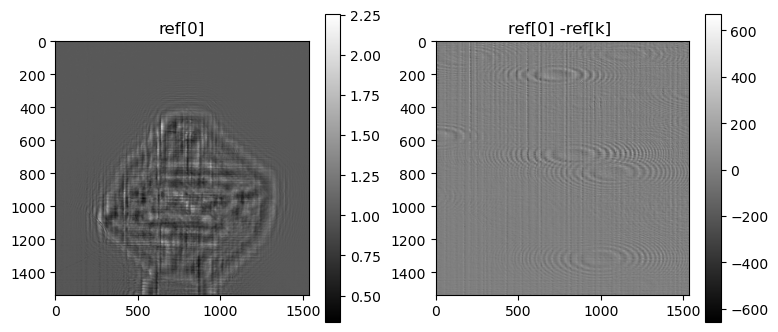

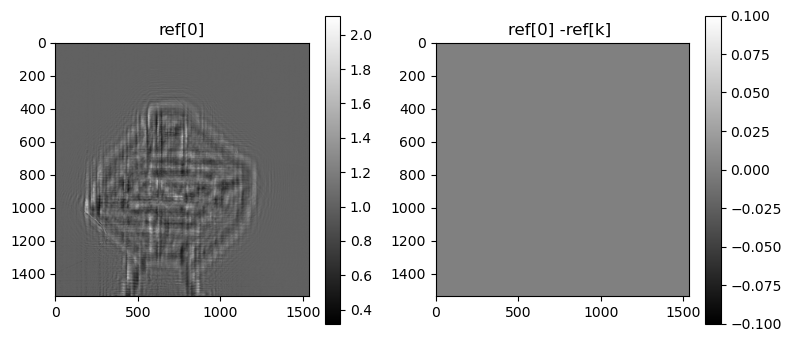

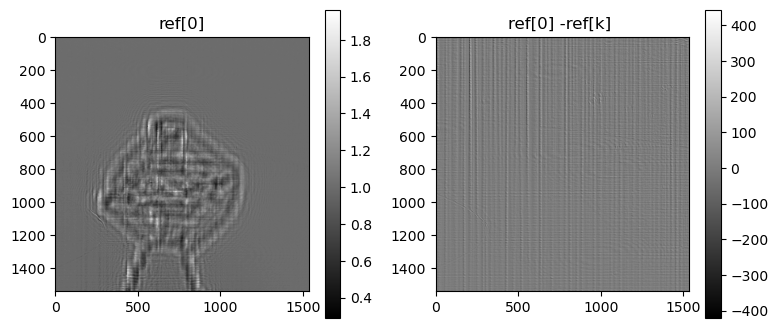

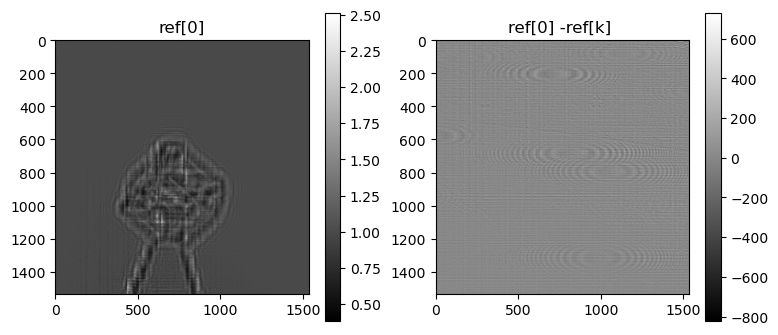

In [7]:
if flg_show:

    for k in range(4):
        fig, axs = plt.subplots(1, 2, figsize=(9, 4))
        im=axs[0].imshow(rdata[k,0],cmap='gray')
        axs[0].set_title('ref[0]')
        fig.colorbar(im)
        im=axs[1].imshow(ref0[1]-ref0[k],cmap='gray')#,vmin=-500,vmax=500)
        axs[1].set_title('ref[0] -ref[k] ')
        fig.colorbar(im)

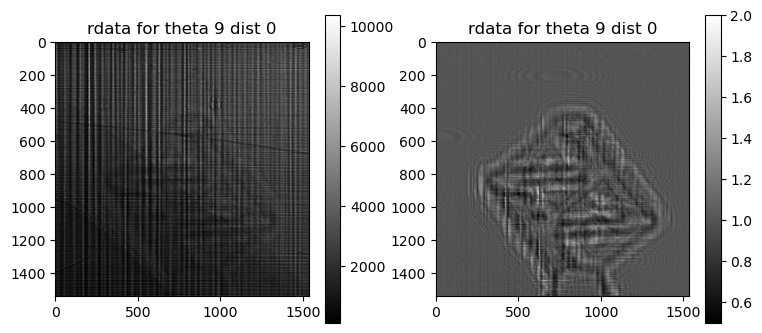

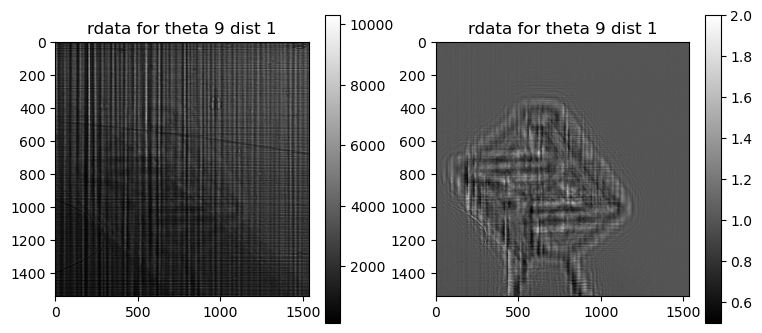

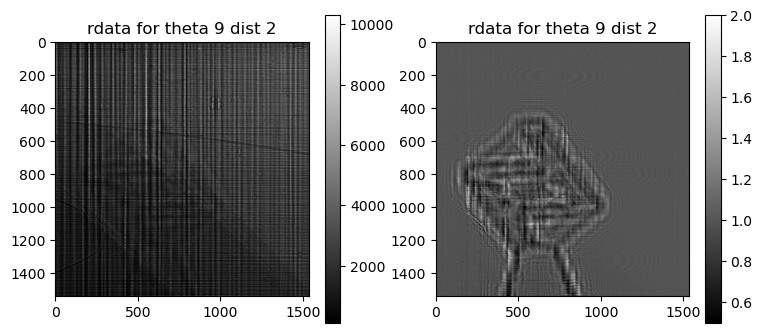

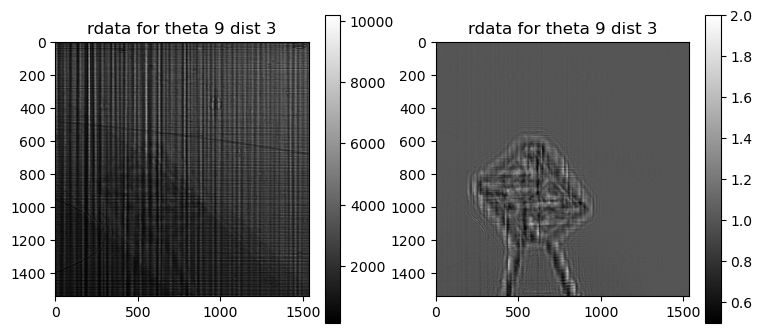

In [8]:
if flg_show:
    for k in range(ndist):
        fig, axs = plt.subplots(1, 2, figsize=(9, 4))
        im=axs[0].imshow(data00[k,-1],cmap='gray')#,vmin = 0.5,vmax=2 )
        axs[0].set_title(f'rdata for theta {ntheta-1} dist {k}')
        fig.colorbar(im)
        im=axs[1].imshow(rdata[k,-1],cmap='gray',vmin = 0.5,vmax=2)
        axs[1].set_title(f'rdata for theta {ntheta-1} dist {k}')
        fig.colorbar(im)

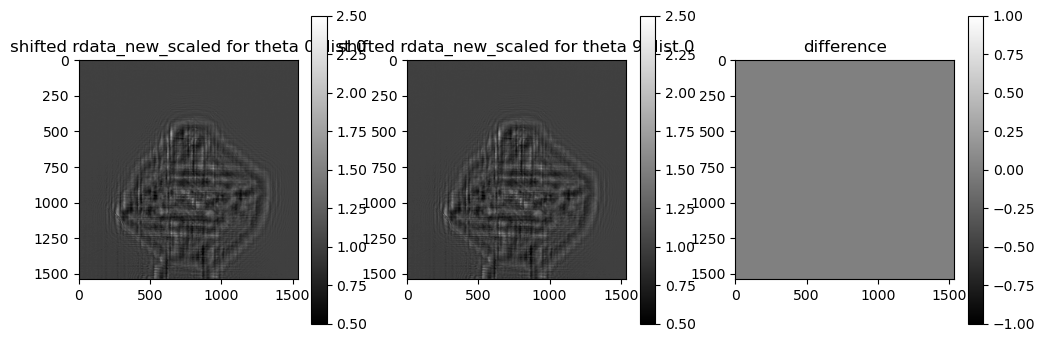

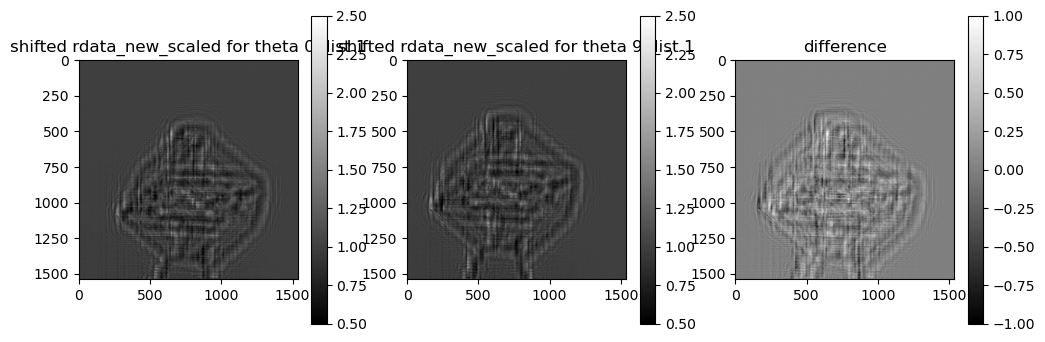

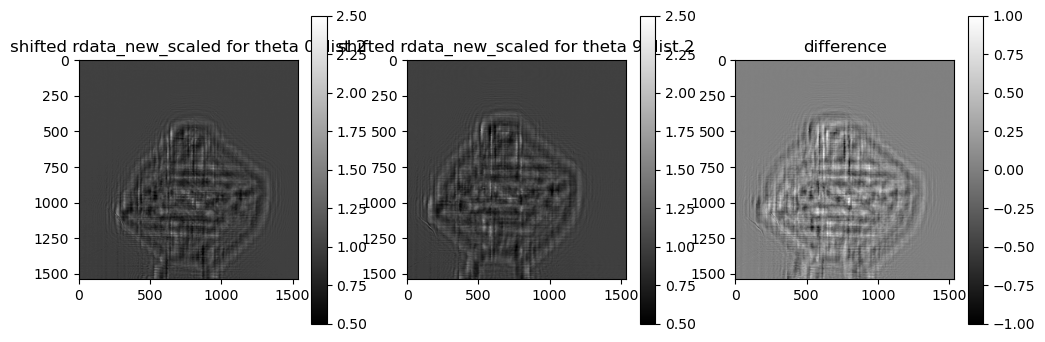

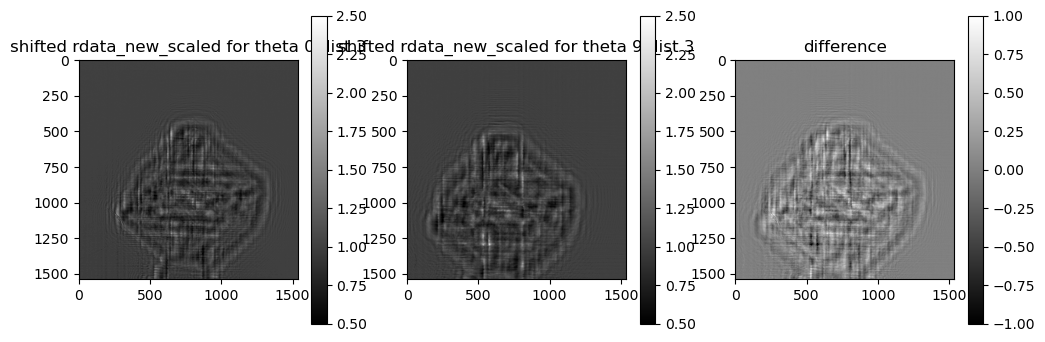

In [9]:
rdata_scaled = rdata.copy()
for j in range(ntheta):
    for k in range(ndist):    
        a = ndimage.zoom(rdata[k,j],1/norm_magnifications[k])
        rdata_scaled[k,j] = a[a.shape[0]//2-n//2:a.shape[0]//2+n//2,a.shape[1]//2-n//2:a.shape[1]//2+n//2]

if flg_show:
    for k in range(ndist):
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        im=axs[0].imshow(rdata_scaled[0,0],cmap='gray',vmin = 0.5,vmax=2.5 )
        axs[0].set_title(f'shifted rdata_new_scaled for theta 0 dist {k}')
        fig.colorbar(im)
        im=axs[1].imshow(rdata_scaled[k,0],cmap='gray',vmin = 0.5,vmax=2.5 )
        axs[1].set_title(f'shifted rdata_new_scaled for theta {ntheta-1} dist {k}')
        fig.colorbar(im)        
        im=axs[2].imshow(rdata_scaled[0,0]-rdata_scaled[k,0],cmap='gray',vmin =-1,vmax=1 )
        axs[2].set_title(f'difference')
        fig.colorbar(im)        

In [10]:
def apply_shift(psi, p):
    """Apply shift for all projections."""
    psi = cp.array(psi)
    p = cp.array(p)
    tmp = cp.pad(psi,((0,0),(n//2,n//2),(n//2,n//2)), 'symmetric')
    [x, y] = cp.meshgrid(cp.fft.rfftfreq(2*n),
                         cp.fft.fftfreq(2*n))
    shift = cp.exp(-2*cp.pi*1j *
                   (x*p[:, 1, None, None]+y*p[:, 0, None, None]))
    res0 = cp.fft.irfft2(shift*cp.fft.rfft2(tmp))
    res = res0[:, n//2:3*n//2, n//2:3*n//2].get()
    return res

def _upsampled_dft(data, ups,
                   upsample_factor=1, axis_offsets=None):

    im2pi = 1j * 2 * np.pi
    tdata = data.copy()
    kernel = (np.tile(np.arange(ups), (data.shape[0], 1))-axis_offsets[:, 1:2])[
        :, :, None]*np.fft.fftfreq(data.shape[2], upsample_factor)
    kernel = np.exp(-im2pi * kernel)
    tdata = np.einsum('ijk,ipk->ijp', kernel, tdata)
    kernel = (np.tile(np.arange(ups), (data.shape[0], 1))-axis_offsets[:, 0:1])[
        :, :, None]*np.fft.fftfreq(data.shape[1], upsample_factor)
    kernel = np.exp(-im2pi * kernel)
    rec = np.einsum('ijk,ipk->ijp', kernel, tdata)

    return rec

def registration_shift(src_image, target_image, upsample_factor=1, space="real"):

    # assume complex data is already in Fourier space
    if space.lower() == 'fourier':
        src_freq = src_image
        target_freq = target_image
    # real data needs to be fft'd.
    elif space.lower() == 'real':
        src_freq = np.fft.fft2(src_image)
        target_freq = np.fft.fft2(target_image)

    # Whole-pixel shift - Compute cross-correlation by an IFFT
    shape = src_freq.shape
    image_product = src_freq * target_freq.conj()
    cross_correlation = np.fft.ifft2(image_product)
    A = np.abs(cross_correlation)
    maxima = A.reshape(A.shape[0], -1).argmax(1)
    maxima = np.column_stack(np.unravel_index(maxima, A[0, :, :].shape))

    midpoints = np.array([np.fix(axis_size / 2)
                          for axis_size in shape[1:]])

    shifts = np.array(maxima, dtype=np.float64)
    ids = np.where(shifts[:, 0] > midpoints[0])
    shifts[ids[0], 0] -= shape[1]
    ids = np.where(shifts[:, 1] > midpoints[1])
    shifts[ids[0], 1] -= shape[2]
    
    if upsample_factor > 1:
        # Initial shift estimate in upsampled grid
        shifts = np.round(shifts * upsample_factor) / upsample_factor
        upsampled_region_size = np.ceil(upsample_factor * 1.5)
        # Center of output array at dftshift + 1
        dftshift = np.fix(upsampled_region_size / 2.0)

        normalization = (src_freq[0].size * upsample_factor ** 2)
        # Matrix multiply DFT around the current shift estimate

        sample_region_offset = dftshift - shifts*upsample_factor
        cross_correlation = _upsampled_dft(image_product.conj(),
                                                upsampled_region_size,
                                                upsample_factor,
                                                sample_region_offset).conj()
        cross_correlation /= normalization
        # Locate maximum and map back to original pixel grid
        A = np.abs(cross_correlation)
        maxima = A.reshape(A.shape[0], -1).argmax(1)
        maxima = np.column_stack(
            np.unravel_index(maxima, A[0, :, :].shape))

        maxima = np.array(maxima, dtype=np.float64) - dftshift

        shifts = shifts + maxima / upsample_factor
           
    return shifts

shifts_random = np.zeros([ndist,ntheta,2],dtype='float32')
for k in range(ndist):
    s = np.loadtxt(f'/data/viktor/id16a/3d_ald4/3d_ald4_ht_10nm_{k+1}_/correct.txt').astype('float32')[st:1500:1500//ntheta]/norm_magnifications[k]    
    shifts_random[k,:,0] = s[:,1]+(1024-(2048+cropy_up-cropy_down)/2)*(1/norm_magnifications[k]-1)#/norm_magnifications[k]
    shifts_random[k,:,1] = s[:,0]+(1024-(2048+cropx_left-cropx_right)/2)*(1/norm_magnifications[k]-1)#/norm_magnifications[k]

shifts_correct3D =np.zeros([ntheta,2],dtype='float32')
s = np.loadtxt(f'/data/viktor/id16a/3d_ald4/3d_ald4_ht_10nm_/correct_correct3D.txt').astype('float32')[st:1500:1500//ntheta]
shifts_correct3D[:,0] = s[:,1]
shifts_correct3D[:,1] = s[:,0]

shifts_random+=shifts_correct3D
# shifts_dist = np.zeros([ndist,ntheta,2],dtype='float32')
# rdata_scaled_tmp=rdata_scaled.copy()
# for j in range(ntheta):
#     for k in range(0,ndist):#!!!!!!!!!!!!!!
#         # print(rdata_scaled[k,j:j+1].shape,(-shifts_random[k,j:j+1]/2**binning).shape)
#         a = apply_shift(rdata_scaled[k,j:j+1],-shifts_random[k,j:j+1]/2**binning)# note first shift then magnification    
#         rdata_scaled_tmp[k,j:j+1] = a    
#         shifts_dist[k,j] = registration_shift(a,rdata_scaled_tmp[0,j:j+1],upsample_factor=10)
        # print(f'{k} {j}: {shifts_random[k,j:j+1]/2**binning} {shifts_dist[k,j]}')
# raise Exception

# Total shifts in pixels before normalized scaling

In [11]:

import scipy.io 
shifts_new = -scipy.io.loadmat('/data/viktor/id16a/3d_ald4/3d_ald4_ht_10nm_/rhapp_py.mat')['rhapp'][:,:,st:1500:1500//ntheta].swapaxes(0,2).swapaxes(0,1)[:ndist]
shifts_new+=shifts_random
shifts_new/=2**binning
shifts = shifts_new



# TEST: Scale initial data to 1 magnification and apply all shifts

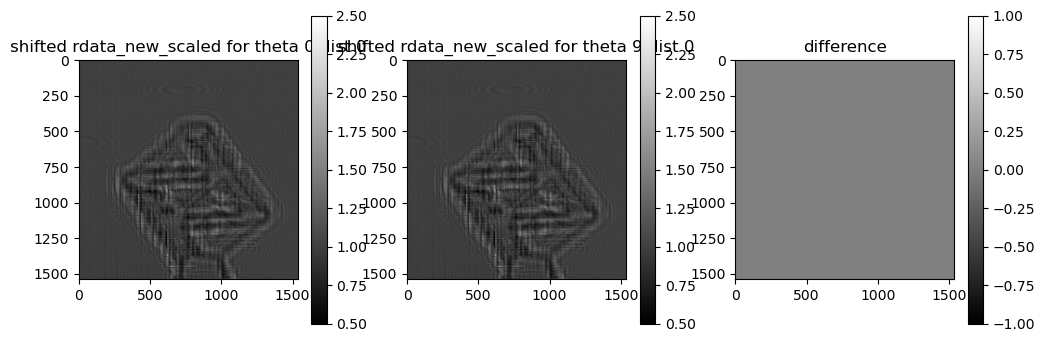

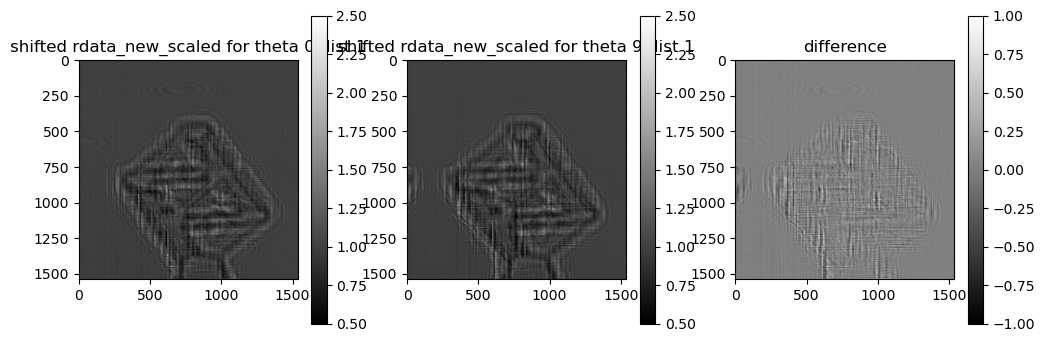

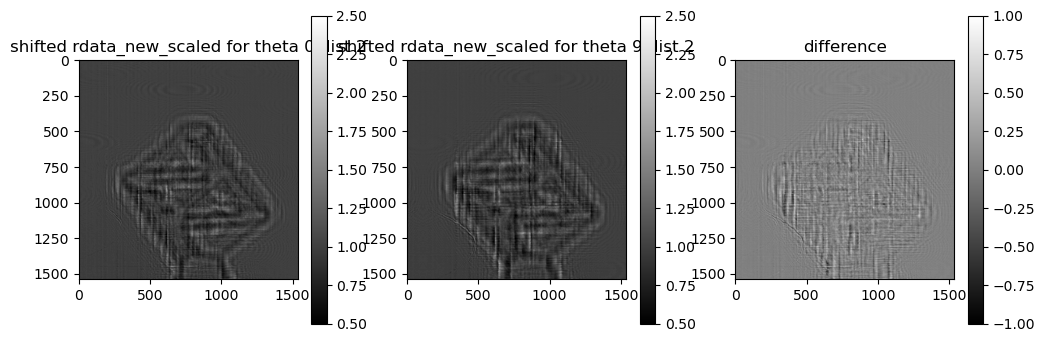

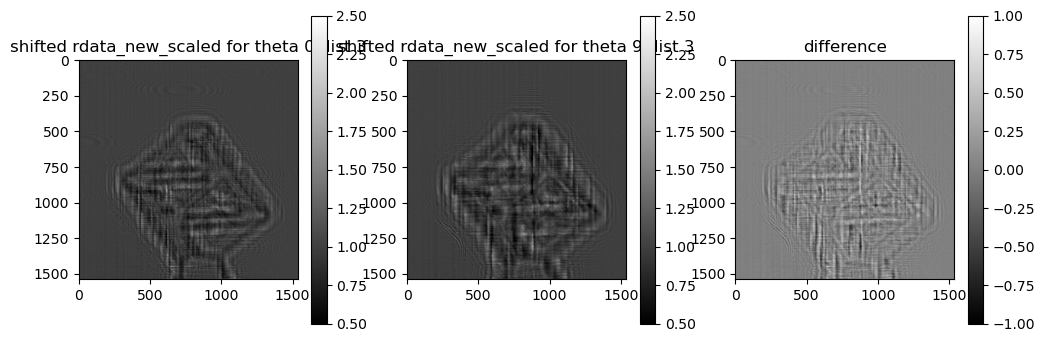

In [12]:
def apply_shift(psi, p):
    """Apply shift for all projections."""
    psi = cp.array(psi)
    p = cp.array(p)
    tmp = cp.pad(psi,((0,0),(n//2,n//2),(n//2,n//2)), 'symmetric')
    [x, y] = cp.meshgrid(cp.fft.rfftfreq(2*n),
                         cp.fft.fftfreq(2*n))
    shift = cp.exp(-2*cp.pi*1j *
                   (x*p[:, 1, None, None]+y*p[:, 0, None, None]))
    res0 = cp.fft.irfft2(shift*cp.fft.rfft2(tmp))
    res = res0[:, n//2:3*n//2, n//2:3*n//2].get()
    return res
rdata_scaled_new = rdata.copy()
for j in range(ntheta):
    for k in range(ndist):    
        a = apply_shift(rdata[k,j:j+1],-shifts[k,j:j+1]*norm_magnifications[k,np.newaxis,np.newaxis])[0]# note first shift then magnification
        a = ndimage.zoom(a,1/norm_magnifications[k])
        rdata_scaled_new[k,j] = a[a.shape[0]//2-n//2:a.shape[0]//2+n//2,a.shape[1]//2-n//2:a.shape[1]//2+n//2]  

if flg_show:
    for k in range(ndist):
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        im=axs[0].imshow(rdata_scaled_new[0,-1],cmap='gray',vmin = 0.5,vmax=2.5 )
        axs[0].set_title(f'shifted rdata_new_scaled for theta 0 dist {k}')
        fig.colorbar(im)
        im=axs[1].imshow(rdata_scaled_new[k,-1],cmap='gray',vmin = 0.5,vmax=2.5 )
        axs[1].set_title(f'shifted rdata_new_scaled for theta {ntheta-1} dist {k}')
        fig.colorbar(im)        
        im=axs[2].imshow(rdata_scaled_new[0,-1]-rdata_scaled_new[k,-1],cmap='gray',vmin =-1,vmax=1 )
        axs[2].set_title(f'difference')
        fig.colorbar(im)          
    

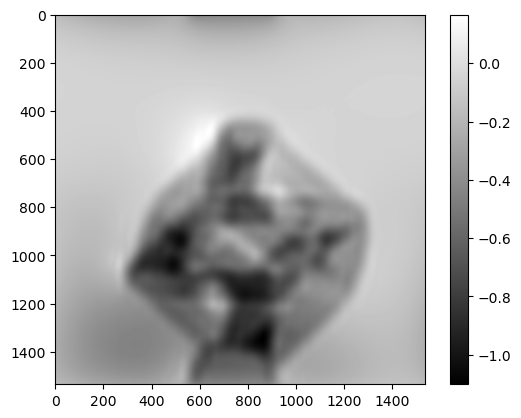

In [13]:
def CTFPurePhase(rads, wlen, dists, fx, fy, alpha):
   """
   weak phase approximation from Cloetens et al. 2002




   Parameters
   ----------
   rad : 2D-array
       projection.
   wlen : float
       X-ray wavelentgth assumes monochromatic source.
   dist : float
       Object to detector distance (propagation distance) in mm.
   fx, fy : ndarray
       Fourier conjugate / spatial frequency coordinates of x and y.
   alpha : float
       regularization factor.
       
   Return
   ------
   phase retrieved projection in real space
   """    
   numerator = 0
   denominator = 0    
   for j in range(0, len(dists)):    
       rad_freq = np.fft.fft2(rads[j])
       taylorExp = np.sin(np.pi*wlen*dists[j]*(fx**2+fy**2)) 
       numerator = numerator + taylorExp * (rad_freq)
       denominator = denominator + 2*taylorExp**2 
   numerator = numerator / len(dists)
   denominator = (denominator / len(dists)) + alpha
   phase = np.real(  np.fft.ifft2(numerator / denominator) )
   phase = 0.5 * phase
   return phase

def multiPaganin(rads, wlen, dists, delta_beta, fx, fy, alpha):
    """
    Phase retrieval method based on Contrast Transfer Function. This 
    method relies on linearization of the direct problem, based  on  the
    first  order  Taylor expansion of the transmittance function.
    Found in Yu et al. 2018 and adapted from Cloetens et al. 1999


    Parameters
    ----------
    rad : 2D-array
        projection.
    wlen : float
        X-ray wavelentgth assumes monochromatic source.
    dist : float
        Object to detector distance (propagation distance) in mm.
    delta : float    
        refractive index decrement
    beta : float    
        absorption index
    fx, fy : ndarray
        Fourier conjugate / spatial frequency coordinates of x and y.
    alpha : float
        regularization factor.
        
    Return
    ------

    phase retrieved projection in real space
    """    
    numerator = 0
    denominator = 0    
    for j in range(0, len(dists)):    
        rad_freq = np.fft.fft2(rads[j])    
        taylorExp = 1 + wlen * dists[j] * np.pi * (delta_beta) * (fx**2+fy**2)
        numerator = numerator + taylorExp * (rad_freq)
        denominator = denominator + taylorExp**2 

    numerator = numerator / len(dists)
    denominator = (denominator / len(dists)) + alpha

    phase = np.log(np.real(  np.fft.ifft2(numerator / denominator) ))    
    phase = (delta_beta) * 0.5 * phase

    
    return phase

distances_rec = (distances/norm_magnifications**2)[:ndist]

fx = np.fft.fftfreq(n,d=voxelsize)
[fx,fy] = np.meshgrid(fx,fx)

wlen = 1.24e-9/energy
recMultiPaganin = np.zeros([ntheta,n,n],dtype='complex64')
for k in range(ntheta):
    rads = rdata_scaled_new[:ndist,k]
    recMultiPaganin[k] = np.exp(1j*multiPaganin(rads, wlen, distances_rec,50, fx, fy, 1e-12))
if flg_show:
    plt.imshow(np.angle(recMultiPaganin[0]),cmap='gray')
    plt.colorbar()
dxchange.write_tiff(np.angle(recMultiPaganin),f'/data/vnikitin/holo/3d_ald/rsame_probe_{same_probe}_{n}_{ntheta}_{ndist}_{st}/MultiPaganin.tiff',overwrite=True)



## Create a solver class for holography

In [14]:
pslv = holotomo.SolverHolo(ntheta, n, ne, ptheta, voxelsize, energy, distances, norm_magnifications,distances2,same_probe=same_probe)


2528


note ptheta parameter is used to define the number of angles for simultaneous processing by 1 gpu. Currently pntheta=ntheta. If the gpu does not have enough memory then ptheta should  be decreased
norm_magnifications are magnifications for different distances, normalized by the magnification for the first distance

## Adjoint test

In [15]:
data = data0.copy()
ref = ref0.copy()
arr1 = np.pad(np.array(data[0]+1j*data[0]).astype('complex64'),((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'symmetric')
prb1 = np.array(ref[:]+1j*ref[:]).astype('complex64')
print(arr1.shape,prb1.shape,shifts_probe.shape)
arr2 = pslv.fwd_holo_batch(arr1,prb1, shifts,shifts_probe=shifts_probe)
arr3 = pslv.adj_holo_batch(arr2,prb1, shifts,shifts_probe=shifts_probe)
prb3 = pslv.adj_holo_prb_batch(arr2,arr1, shifts,shifts_probe=shifts_probe)



print(np.sum(arr1*np.conj(arr3)))
print(np.sum(arr2*np.conj(arr2)))
print(np.sum(prb1*np.conj(prb3)))

(10, 2528, 2528) (4, 1536, 1536) (4, 2)
(1.3823604e+22-1303123000000000j)
(1.3823593e+22-6822847000j)
(1.3816741e+22-1.02937674e+18j)


In [16]:
def line_search(minf, gamma, fu, fu0, fd, fd0):
    """ Line search for the step sizes gamma"""
    while(minf(fu,fu0)-minf(fu+gamma*fd, fu0+gamma*fd0) < 0 and gamma > 0.125):
        gamma *= 0.5
    if(gamma <= 0.125):  # direction not found
        #print('no direction')
        gamma = 0
    return gamma

## $\ \sum_j\sum_i||\mathcal{G}_{d_j}((\mathcal{G}_{d'_j}q)(M_j S_{r_{ij}}\psi_i))|-\sqrt{\text{I}_{ij}}\|^2_2 + \||\mathcal{G}_{d_0}q|-\sqrt{\text{I}_r}\|_2^2\to \text{min}_{\psi_i,q}$ 

In [17]:

from holotomo.utils import chunk
def adj_holo_batch_ext(pslv,fpsi, data, prb, shifts=None,shifts_probe=None, code=None, shifts_code=None):
    """Batch of Holography transforms"""
    res = np.zeros([ntheta, pslv.ne, pslv.ne], dtype='complex64')
    prb_gpu = cp.array(prb)
    shifts_gpu = None        
    shifts_code_gpu = None
    code_gpu = None

    if code is not None:
        code_gpu = cp.array(code)   
    for ids in chunk(range(pslv.ntheta), pslv.ptheta):
        # copy data part to gpu
        fpsi_gpu = cp.array(fpsi[:, ids])
        data_gpu = cp.array(data[:, ids])
            
        if shifts is not None:
            shifts_gpu = cp.array(shifts[:,ids])
        if shifts_code is not None:
            shifts_code_gpu = cp.array(shifts_code[:,ids])
        fpsi_gpu = fpsi_gpu-data_gpu*cp.exp(1j*(cp.angle(fpsi_gpu)))        
        # Radon transform
        res_gpu = pslv.adj_holo(fpsi_gpu, prb_gpu, shifts_gpu, code_gpu, shifts_code_gpu,shifts_probe=shifts_probe)
        # copy result to cpu
        res[ids] = res_gpu.get()
    return res

def adj_holo_prb_batch_ext(pslv, fpsi, data, psi, shifts=None,shifts_probe=None, code=None, shifts_code=None):
        """Batch of Holography transforms"""
        res = np.zeros([len(pslv.distances), pslv.n, pslv.n], dtype='complex64')
        shifts_gpu = None        
        shifts_code_gpu = None
        code_gpu = None
        if code is not None:
            code_gpu = cp.array(code)   
        for ids in chunk(range(pslv.ntheta), pslv.ptheta):
            # copy data part to gpu
            fpsi_gpu = cp.array(fpsi[:, ids])
            psi_gpu = cp.array(psi[ids])
            data_gpu = cp.array(data[:, ids])
            
            if shifts is not None:
                shifts_gpu = cp.array(shifts[:,ids])
            if shifts_code is not None:
                shifts_code_gpu = cp.array(shifts_code[:,ids])
            # Radon transform
            fpsi_gpu = fpsi_gpu-data_gpu*cp.exp(1j*(cp.angle(fpsi_gpu)))                
            # fprb-data*np.exp(1j*np.angle(fprb))
            res_gpu = pslv.adj_holo_prb(fpsi_gpu, psi_gpu, shifts_gpu,code_gpu,shifts_code_gpu,shifts_probe=shifts_probe)
            # copy result to cpu
            res += res_gpu.get()
        return res
import time
def cg_holo_batch2(pslv, pslv0, data, data_ref, init, init_prb,  piter,shifts,shifts_probe, upd_psi=True, upd_prb=False,step=1,vis_step=1,gammapsi0=1,gammaprb0=1):
    """Conjugate gradients method for holography"""

    data = np.sqrt(data)
    data_ref = np.sqrt(data_ref)
    
    # minimization functional
    def minf(fpsi,fprb):
        f = np.linalg.norm(np.abs(fpsi)-data)**2            
        f += np.linalg.norm(np.abs(fprb)-data_ref)**2        
        return f        
    
    psi = init.copy()
    prb = init_prb.copy()
    gammapsi = gammapsi0
    gammaprb = gammaprb0
    
    psi_nil = psi[:1]*0+1
    shifts_nil = shifts[:,:1]*0
    conv = np.zeros([piter])
    tt=np.zeros(10)
    for i in range(piter):
        if upd_psi:
            t = time.time()
            fpsi = pslv.fwd_holo_batch(psi,prb,shifts,shifts_probe=shifts_probe)          
            tt[0] = time.time()-t
            # d = -pslv.adj_holo_batch(fpsi-data*np.exp(1j*(np.angle(fpsi))), prb,shifts)/np.max(np.abs(prb))**2
            t = time.time()
            grad = adj_holo_batch_ext(pslv,fpsi,data, prb,shifts,shifts_probe=shifts_probe)/np.max(np.abs(prb))**2
            tt[1] = time.time()-t
            t = time.time()
            if i == 0 or gammapsi==0:
                d = -grad
            else:
                # d = -grad+np.linalg.norm(grad)**2 / \
                #     ((np.sum(np.conj(d)*(grad-grad0))))*d
                d = -grad+np.linalg.norm(grad)**2 / \
                    (np.vdot(d,grad-grad0))*d
            tt[2] = time.time()-t
            grad0 = grad           
            # line search
            t = time.time()
            fd = pslv.fwd_holo_batch(d, prb,shifts,shifts_probe=shifts_probe)                 
            tt[3] = time.time()-t
            t = time.time()
            gammapsi = line_search(minf, gammapsi0, fpsi, 0, fd, 0)
            tt[4] = time.time()-t
            psi = psi+gammapsi*d
            
        if upd_prb:
            t = time.time()
            fprb = pslv.fwd_holo_batch(psi,prb,shifts,shifts_probe=shifts_probe)
            fprb0 = pslv0.fwd_holo_batch(psi_nil,prb,shifts_nil,shifts_probe=shifts_probe)
            tt[5] = time.time()-t
            
            # dprb = -pslv.adj_holo_prb_batch(fprb-data*np.exp(1j*np.angle(fprb)),psi,shifts)#/ndist**2
            # dprb -= pslv0.adj_holo_prb_batch(fprb0-data_ref*np.exp(1j*np.angle(fprb0)),psi_nil,shifts_nil)
            t = time.time()
            gradprb = adj_holo_prb_batch_ext(pslv,fprb,data,psi,shifts,shifts_probe=shifts_probe)#/ndist**2            
            gradprb += adj_holo_prb_batch_ext(pslv0,fprb0,data_ref,psi_nil,shifts_nil,shifts_probe=shifts_probe)
            gradprb *= 1/((pslv.ntheta+1))
            tt[6] = time.time()-t
            t = time.time()
            if i == 0 or gammaprb==0:
                dprb = -gradprb
            else:
                # print(np.sum(np.conj(dprb)*(gradprb-gradprb0)))
                # print(np.vdot(dprb,gradprb-gradprb0))      
                # dprb = -gradprb+np.linalg.norm(gradprb)**2 / \
                    # ((np.sum(np.conj(dprb)*(gradprb-gradprb0))))*dprb
                dprb = -gradprb+np.linalg.norm(gradprb)**2 / \
                    (np.vdot(dprb,gradprb-gradprb0))*dprb
            tt[7] = time.time()-t
            gradprb0 = gradprb

            # line search
            t = time.time()
            fdprb = pslv.fwd_holo_batch(psi, dprb,shifts,shifts_probe=shifts_probe)
            fdprb0 = pslv0.fwd_holo_batch(psi_nil, dprb,shifts_nil,shifts_probe=shifts_probe)
            tt[8] = time.time()-t
            t = time.time()
            gammaprb = line_search(minf, gammaprb0, fprb, fprb0, fdprb, fdprb0)
            prb = prb + gammaprb*dprb
            tt[9] = time.time()-t
        if i<3:
            print(np.sum(tt))
            tt=tt/np.sum(tt)*100
            print(f'fwd psi {tt[0]:.2e}, adj psi {tt[1]:.2e}, grad psi {tt[2]:.2e},fwd d {tt[3]:.2e}, line search {tt[4]:.2e}')
            print(f'fwd prb {tt[5]:.2e}, adj prb {tt[6]:.2e}, grad prb {tt[7]:.2e},fwd dprb {tt[8]:.2e}, line search {tt[9]:.2e}')            
            print(np.sum(tt))
        
        if i%vis_step==0:  
            if flg_show:
                fig, axs = plt.subplots(1, 2, figsize=(10, 5))
                im=axs[0].imshow(np.angle(recMultiPaganin[0]),cmap='gray')
                axs[0].set_title('reconstructed MultiPaganin phase')
                fig.colorbar(im)
                im=axs[1].imshow(np.angle(psi[0,ne//2-n//2:ne//2+n//2,ne//2-n//2:ne//2+n//2]),cmap='gray')
                axs[1].set_title('reconstructed phase')
                fig.colorbar(im)                
                plt.show()
            dxchange.write_tiff(np.angle(psi),f'/data/vnikitin/holo/3d_ald/rfinal_probe_{same_probe}_{pslv.n}_{ntheta}_{ndist}_{st}/r{i:05}.tiff',overwrite=True)
            dxchange.write_tiff(np.angle(psi[0]),f'/data/vnikitin/holo/3d_ald/rfinal_probe_{same_probe}_{pslv.n}_{ntheta}_{ndist}_{st}/o{i:05}.tiff',overwrite=True)
            dxchange.write_tiff(np.abs(prb[0]),f'/data/vnikitin/holo/3d_ald/rfinal_probe_{same_probe}_{pslv.n}_{ntheta}_{ndist}_{st}/pabs{i:05}.tiff',overwrite=True)
            dxchange.write_tiff(np.angle(prb[0]),f'/data/vnikitin/holo/3d_ald/rfinal_probe_{same_probe}_{pslv.n}_{ntheta}_{ndist}_{st}/pang{i:05}.tiff',overwrite=True)        
        
        if i%step==0:
            fprb = pslv.fwd_holo_batch(psi,prb,shifts,shifts_probe=shifts_probe)
            fprb0 = pslv0.fwd_holo_batch(psi_nil,prb,shifts_nil,shifts_probe=shifts_probe)            
            err=minf(fprb,fprb0)
            conv[i]=err
            print(f'{i}) {gammapsi=} {gammaprb=}, {err=:1.5e}', flush=True)
            np.save(f'/data/vnikitin/holo/3d_ald/rfinal_probe_{same_probe}_{pslv.n}_{ntheta}_{ndist}_{st}/conv',conv)
        
            
    return psi,prb,conv


2528
2528
0.9069292545318604
fwd psi 0.00e+00, adj psi 0.00e+00, grad psi 0.00e+00,fwd d 0.00e+00, line search 0.00e+00
fwd prb 2.44e+01, adj prb 3.38e+01, grad prb 2.67e+00,fwd dprb 2.25e+01, line search 1.66e+01
100.0


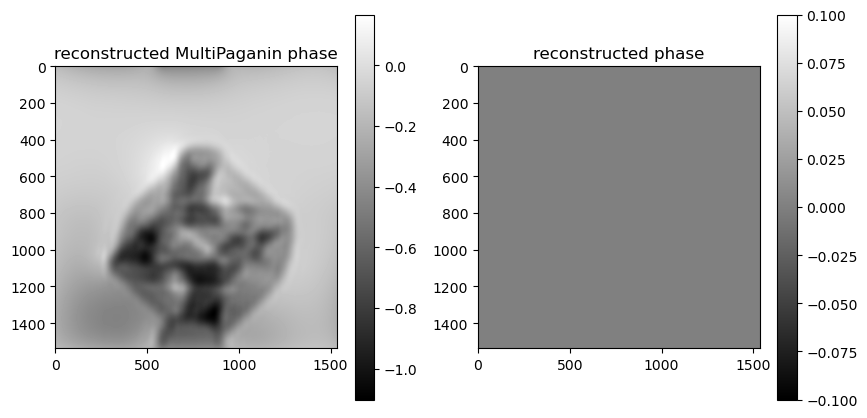

0) gammapsi=0.5 gammaprb=1, err=3.82684e+06
0.9455163478851318
fwd psi 0.00e+00, adj psi 0.00e+00, grad psi 0.00e+00,fwd d 0.00e+00, line search 0.00e+00
fwd prb 2.18e+01, adj prb 3.23e+01, grad prb 8.24e+00,fwd dprb 2.19e+01, line search 1.58e+01
100.0
1) gammapsi=0.5 gammaprb=1, err=3.82683e+06
0.9348235130310059
fwd psi 0.00e+00, adj psi 0.00e+00, grad psi 0.00e+00,fwd d 0.00e+00, line search 0.00e+00
fwd prb 2.19e+01, adj prb 3.20e+01, grad prb 8.11e+00,fwd dprb 2.21e+01, line search 1.60e+01
100.0
2) gammapsi=0.5 gammaprb=1, err=3.82683e+06
3) gammapsi=0.5 gammaprb=1, err=3.82683e+06
4) gammapsi=0.5 gammaprb=1, err=3.82683e+06
5) gammapsi=0.5 gammaprb=1, err=3.82683e+06
6) gammapsi=0.5 gammaprb=1, err=3.82683e+06
7) gammapsi=0.5 gammaprb=1, err=3.82683e+06
8) gammapsi=0.5 gammaprb=1, err=3.82683e+06
9) gammapsi=0.5 gammaprb=1, err=3.82683e+06
10) gammapsi=0.5 gammaprb=1, err=3.82683e+06
11) gammapsi=0.5 gammaprb=1, err=3.82683e+06
12) gammapsi=0.5 gammaprb=1, err=3.82683e+06
13) g

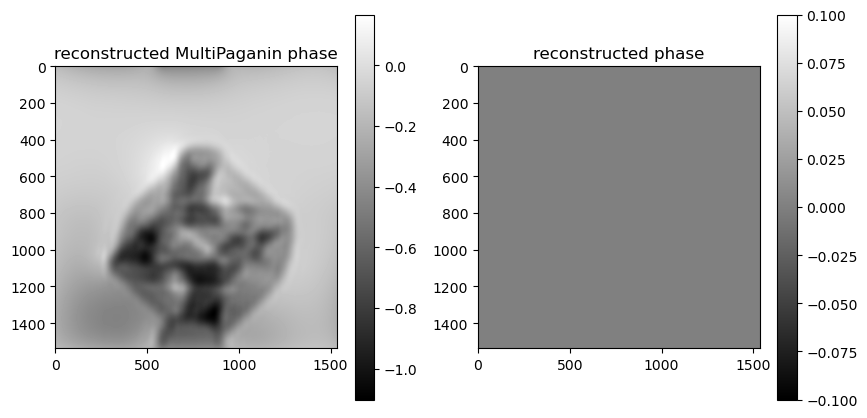

17) gammapsi=0.5 gammaprb=1, err=3.82683e+06
18) gammapsi=0.5 gammaprb=1, err=3.82683e+06
19) gammapsi=0.5 gammaprb=1, err=3.82683e+06
20) gammapsi=0.5 gammaprb=1, err=3.82683e+06
21) gammapsi=0.5 gammaprb=1, err=3.82683e+06
22) gammapsi=0.5 gammaprb=1, err=3.82683e+06
23) gammapsi=0.5 gammaprb=1, err=3.82683e+06
24) gammapsi=0.5 gammaprb=1, err=3.82683e+06
25) gammapsi=0.5 gammaprb=1, err=3.82683e+06
26) gammapsi=0.5 gammaprb=0.5, err=3.82683e+06
27) gammapsi=0.5 gammaprb=1, err=3.82683e+06
28) gammapsi=0.5 gammaprb=1, err=3.82683e+06
29) gammapsi=0.5 gammaprb=1, err=3.82683e+06
30) gammapsi=0.5 gammaprb=1, err=3.82683e+06
31) gammapsi=0.5 gammaprb=1, err=3.82683e+06
32) gammapsi=0.5 gammaprb=1, err=3.82683e+06


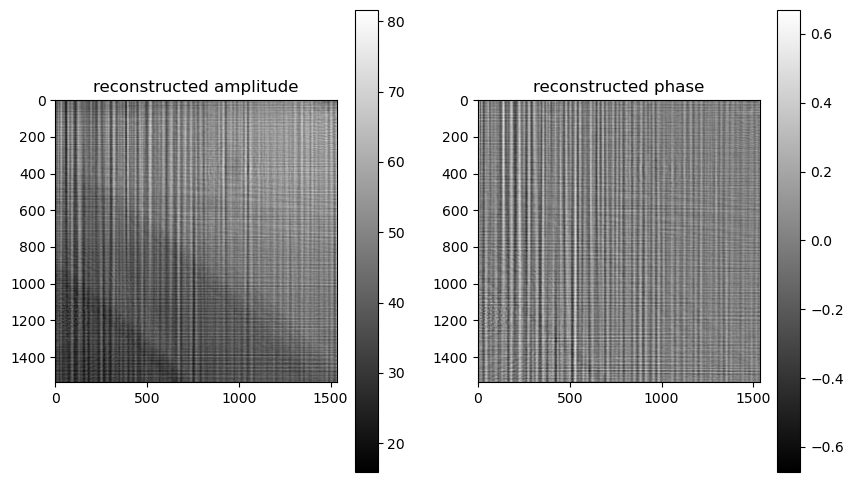

In [18]:

pslv = holotomo.SolverHolo(ntheta, n, ne, ptheta, voxelsize, energy, distances, norm_magnifications, distances2,same_probe=same_probe) 
pslv0 = holotomo.SolverHolo(1, n, ne, 1, voxelsize, energy, distances, norm_magnifications, distances2,same_probe=same_probe) 


rec = np.ones([1,ne,ne],dtype='complex64')
rec_prb = np.ones([ndist,n,n],dtype='complex64')        
data_ref = ref0[:,np.newaxis]
shifts_nil = np.array(shifts)[:,:1]*0
_,rec_prb0,_ = cg_holo_batch2(pslv0, pslv0, data_ref, data_ref, rec, rec_prb, 33, shifts_nil,shifts_probe, False,True,1,17,0.5,1)
if flg_show:
    fig, axs = plt.subplots(1, 2, figsize=(10, 6))
    im=axs[0].imshow(np.abs(rec_prb0[0]),cmap='gray')
    axs[0].set_title('reconstructed amplitude')
    fig.colorbar(im)
    im=axs[1].imshow(np.angle(rec_prb0[0]),cmap='gray')
    axs[1].set_title('reconstructed phase')
    fig.colorbar(im)

In [19]:

# shifts_rec = np.array(shifts)
# rec = np.ones([ntheta,pslv.ne,pslv.ne],dtype='complex64')
# rec = np.pad(recMultiPaganin,((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'edge')
# # use only the abs value of the probe as initial guess
# rec_prb[:] = rec_prb0
# rec,rec_prb,conv = cg_holo_batch2(pslv, pslv0, data, data_ref, rec, rec_prb, niter, shifts_rec,shifts_probe, True,True,8,iter_step, 1,2)

In [20]:
rec = np.ones([ntheta,pslv.ne,pslv.ne],dtype='complex64')
rec = np.pad(recMultiPaganin,((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'edge')

data0 = data.copy()
data_ref0 = data_ref.copy()
rec0 = rec.copy()
prb0 = rec_prb0.copy()
n0 = n
ne0 = ne
voxelsize0 = voxelsize
shifts_rec0 = np.array(shifts)
shifts_probe0 = shifts_probe.copy()


n=192,ne=316,voxelsize=7.999668874172185e-08
316
316
0.2912871837615967
fwd psi 1.55e+01, adj psi 1.34e+01, grad psi 5.71e-01,fwd d 9.48e+00, line search 5.30e+00
fwd prb 1.69e+01, adj prb 1.94e+01, grad prb 1.46e-01,fwd dprb 1.66e+01, line search 2.74e+00
100.0


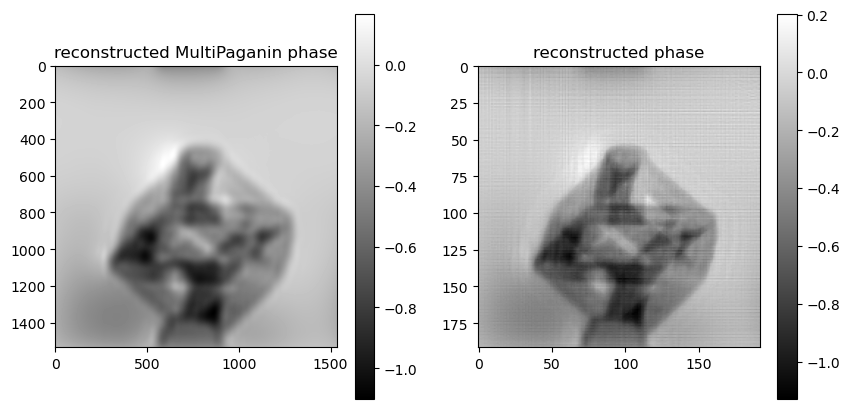

0) gammapsi=1 gammaprb=2, err=4.36877e+06
0.27782487869262695
fwd psi 1.23e+01, adj psi 1.48e+01, grad psi 2.33e+00,fwd d 1.21e+01, line search 2.50e+00
fwd prb 1.73e+01, adj prb 1.86e+01, grad prb 3.44e-01,fwd dprb 1.69e+01, line search 2.80e+00
100.0
1) gammapsi=1 gammaprb=2, err=1.47683e+06
0.27908873558044434
fwd psi 1.19e+01, adj psi 1.47e+01, grad psi 2.37e+00,fwd d 1.22e+01, line search 2.46e+00
fwd prb 1.73e+01, adj prb 1.87e+01, grad prb 3.41e-01,fwd dprb 1.72e+01, line search 2.81e+00
100.0
2) gammapsi=1 gammaprb=2, err=9.24164e+05
3) gammapsi=1 gammaprb=2, err=7.56546e+05
4) gammapsi=1 gammaprb=0.5, err=6.71445e+05
5) gammapsi=1 gammaprb=0.25, err=6.18187e+05
6) gammapsi=1 gammaprb=0.5, err=5.89288e+05
7) gammapsi=1 gammaprb=0.25, err=5.68808e+05
8) gammapsi=1 gammaprb=0, err=5.55072e+05
9) gammapsi=1 gammaprb=2, err=5.35714e+05
10) gammapsi=0.5 gammaprb=2, err=5.19928e+05
11) gammapsi=0.25 gammaprb=2, err=5.08133e+05
12) gammapsi=0.25 gammaprb=0.25, err=5.03339e+05
13) gamm

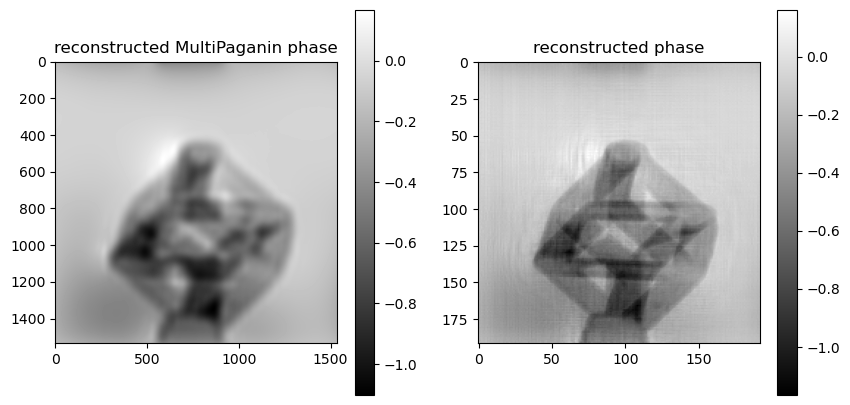

32) gammapsi=1 gammaprb=1.0, err=3.03111e+05
33) gammapsi=0.25 gammaprb=2, err=3.00279e+05
34) gammapsi=0.5 gammaprb=2, err=2.97690e+05
35) gammapsi=0.25 gammaprb=2, err=2.95976e+05
36) gammapsi=0.25 gammaprb=2, err=2.93160e+05
37) gammapsi=0 gammaprb=2, err=2.89544e+05
38) gammapsi=1 gammaprb=2, err=2.87961e+05
39) gammapsi=0.5 gammaprb=1.0, err=2.82871e+05
40) gammapsi=0.25 gammaprb=1.0, err=2.80194e+05
41) gammapsi=0.5 gammaprb=2, err=2.79010e+05
42) gammapsi=0.5 gammaprb=2, err=2.77574e+05
43) gammapsi=0.25 gammaprb=1.0, err=2.75311e+05
44) gammapsi=0.5 gammaprb=2, err=2.73717e+05
45) gammapsi=0.5 gammaprb=2, err=2.72502e+05
46) gammapsi=0.5 gammaprb=1.0, err=2.71195e+05
47) gammapsi=0.5 gammaprb=2, err=2.69583e+05
48) gammapsi=0 gammaprb=2, err=2.64690e+05
49) gammapsi=1 gammaprb=1.0, err=2.60945e+05
50) gammapsi=0.5 gammaprb=1.0, err=2.56390e+05
51) gammapsi=0.5 gammaprb=2, err=2.55101e+05
52) gammapsi=0.25 gammaprb=2, err=2.53796e+05
53) gammapsi=0.25 gammaprb=1.0, err=2.52833e+

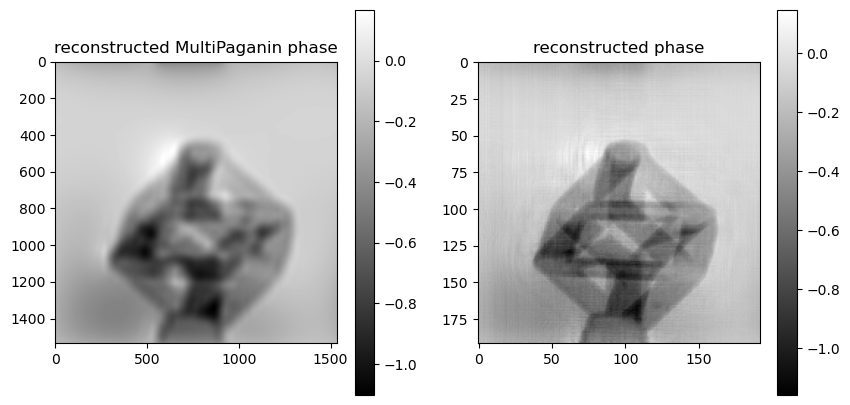

64) gammapsi=0.25 gammaprb=2, err=2.36505e+05
65) gammapsi=0.5 gammaprb=2, err=2.35324e+05
66) gammapsi=0.25 gammaprb=2, err=2.34008e+05
67) gammapsi=0.25 gammaprb=2, err=2.32890e+05
68) gammapsi=0 gammaprb=2, err=2.31192e+05
69) gammapsi=1 gammaprb=2, err=2.28806e+05
70) gammapsi=0.5 gammaprb=1.0, err=2.26835e+05
71) gammapsi=0.5 gammaprb=2, err=2.25988e+05
72) gammapsi=0.5 gammaprb=2, err=2.25389e+05
73) gammapsi=0.25 gammaprb=1.0, err=2.24885e+05
74) gammapsi=0.25 gammaprb=2, err=2.24126e+05
75) gammapsi=0 gammaprb=2, err=2.23178e+05
76) gammapsi=1 gammaprb=2, err=2.21668e+05
77) gammapsi=0.5 gammaprb=2, err=2.20817e+05
78) gammapsi=0.5 gammaprb=2, err=2.19727e+05
79) gammapsi=0.25 gammaprb=2, err=2.18689e+05
80) gammapsi=0.5 gammaprb=2, err=2.17767e+05
81) gammapsi=0.5 gammaprb=2, err=2.17240e+05
82) gammapsi=0.5 gammaprb=2, err=2.16682e+05
83) gammapsi=0.25 gammaprb=2, err=2.16125e+05
84) gammapsi=0.25 gammaprb=2, err=2.15419e+05
85) gammapsi=0.25 gammaprb=2, err=2.14466e+05
86) g

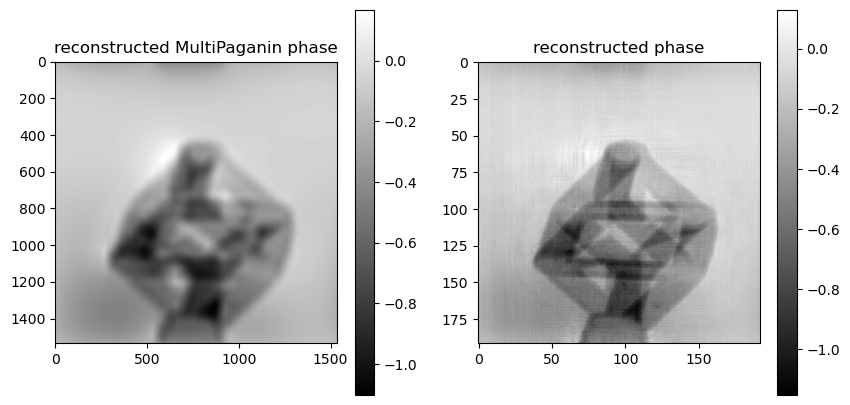

96) gammapsi=0.5 gammaprb=2, err=2.02512e+05
97) gammapsi=1 gammaprb=2, err=2.02381e+05
98) gammapsi=0.25 gammaprb=2, err=2.02124e+05
99) gammapsi=0.25 gammaprb=2, err=2.01689e+05
100) gammapsi=0 gammaprb=2, err=2.00595e+05
101) gammapsi=1 gammaprb=2, err=1.99802e+05
102) gammapsi=0.5 gammaprb=2, err=1.98829e+05
103) gammapsi=0.5 gammaprb=2, err=1.98558e+05
104) gammapsi=1 gammaprb=2, err=1.97975e+05
105) gammapsi=0.5 gammaprb=2, err=1.97475e+05
106) gammapsi=0.5 gammaprb=2, err=1.97022e+05
107) gammapsi=0.5 gammaprb=2, err=1.96824e+05
108) gammapsi=0.25 gammaprb=2, err=1.96279e+05
109) gammapsi=0.25 gammaprb=2, err=1.95854e+05
110) gammapsi=0 gammaprb=2, err=1.95212e+05
111) gammapsi=1 gammaprb=2, err=1.93817e+05
112) gammapsi=0.5 gammaprb=2, err=1.93211e+05
113) gammapsi=1 gammaprb=2, err=1.92724e+05
114) gammapsi=0.5 gammaprb=2, err=1.92297e+05
115) gammapsi=0.25 gammaprb=2, err=1.91973e+05
116) gammapsi=0 gammaprb=2, err=1.91276e+05
117) gammapsi=1 gammaprb=2, err=1.90756e+05
118) 

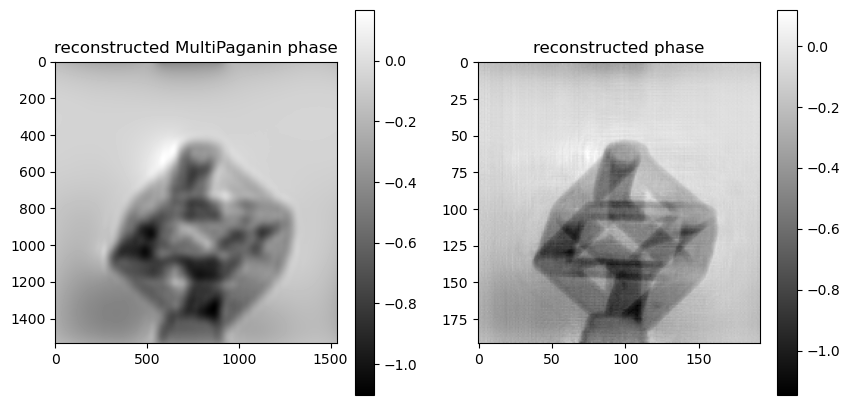

128) gammapsi=0.25 gammaprb=2, err=1.86573e+05
129) gammapsi=0.25 gammaprb=2, err=1.86271e+05
130) gammapsi=0.5 gammaprb=2, err=1.86069e+05
131) gammapsi=0.25 gammaprb=2, err=1.85774e+05
132) gammapsi=0.25 gammaprb=2, err=1.85403e+05
133) gammapsi=0.25 gammaprb=2, err=1.85168e+05
134) gammapsi=0.25 gammaprb=2, err=1.84768e+05
135) gammapsi=0.5 gammaprb=2, err=1.84487e+05
136) gammapsi=0.25 gammaprb=2, err=1.84097e+05
137) gammapsi=0.25 gammaprb=2, err=1.83659e+05
138) gammapsi=0 gammaprb=2, err=1.83282e+05
139) gammapsi=1 gammaprb=2, err=1.82106e+05
140) gammapsi=1 gammaprb=1.0, err=1.81664e+05
141) gammapsi=1 gammaprb=1.0, err=1.81245e+05
142) gammapsi=1 gammaprb=0.5, err=1.81067e+05
143) gammapsi=1 gammaprb=0.25, err=1.80890e+05
144) gammapsi=0.5 gammaprb=0.5, err=1.80706e+05
145) gammapsi=0 gammaprb=1.0, err=1.80564e+05
146) gammapsi=1 gammaprb=0, err=1.80213e+05
147) gammapsi=1 gammaprb=2, err=1.80025e+05
148) gammapsi=0.5 gammaprb=2, err=1.79746e+05
149) gammapsi=0.5 gammaprb=2, e

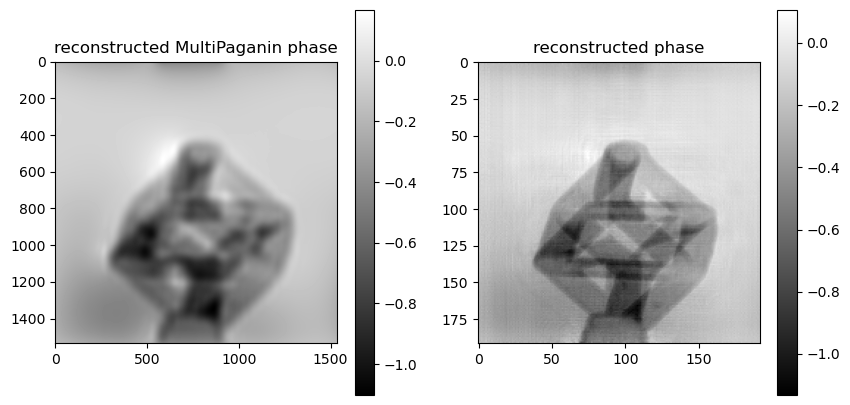

160) gammapsi=1 gammaprb=0.25, err=1.76238e+05
161) gammapsi=1 gammaprb=1.0, err=1.75891e+05
162) gammapsi=1 gammaprb=1.0, err=1.75785e+05
163) gammapsi=1 gammaprb=0.5, err=1.75529e+05
164) gammapsi=1 gammaprb=2, err=1.75371e+05
165) gammapsi=0 gammaprb=2, err=1.74731e+05
166) gammapsi=1 gammaprb=1.0, err=1.74195e+05
167) gammapsi=1 gammaprb=2, err=1.74027e+05
168) gammapsi=0 gammaprb=2, err=1.73327e+05
169) gammapsi=1 gammaprb=2, err=1.72959e+05
170) gammapsi=1 gammaprb=1.0, err=1.72856e+05
171) gammapsi=0.5 gammaprb=1.0, err=1.72457e+05
172) gammapsi=0.5 gammaprb=2, err=1.72297e+05
173) gammapsi=0.5 gammaprb=0.5, err=1.72228e+05
174) gammapsi=0.5 gammaprb=2, err=1.72138e+05
175) gammapsi=0 gammaprb=2, err=1.71579e+05
176) gammapsi=1 gammaprb=2, err=1.71399e+05
177) gammapsi=0.5 gammaprb=1.0, err=1.71068e+05
178) gammapsi=0.5 gammaprb=2, err=1.70872e+05
179) gammapsi=1 gammaprb=2, err=1.70682e+05
180) gammapsi=0.25 gammaprb=2, err=1.70516e+05
181) gammapsi=1 gammaprb=2, err=1.70349e+0

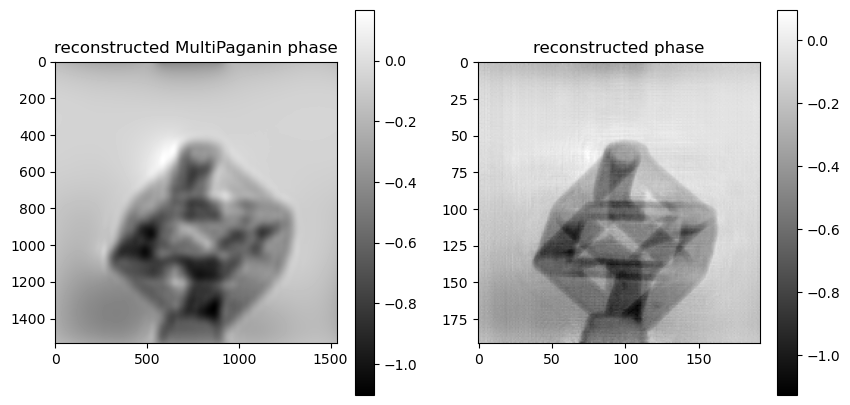

192) gammapsi=0.5 gammaprb=2, err=1.67687e+05
193) gammapsi=1 gammaprb=2, err=1.67593e+05
194) gammapsi=0 gammaprb=2, err=1.67263e+05
195) gammapsi=1 gammaprb=2, err=1.67091e+05
196) gammapsi=0.5 gammaprb=2, err=1.66991e+05
197) gammapsi=0 gammaprb=2, err=1.66667e+05
198) gammapsi=1 gammaprb=2, err=1.66500e+05
199) gammapsi=1 gammaprb=2, err=1.66357e+05
200) gammapsi=1 gammaprb=2, err=1.66243e+05
201) gammapsi=1 gammaprb=2, err=1.66080e+05
202) gammapsi=1 gammaprb=2, err=1.65903e+05
203) gammapsi=1 gammaprb=2, err=1.65675e+05
204) gammapsi=0.5 gammaprb=2, err=1.65515e+05
205) gammapsi=1 gammaprb=2, err=1.65340e+05
206) gammapsi=1 gammaprb=2, err=1.64873e+05
207) gammapsi=1 gammaprb=2, err=1.64571e+05
208) gammapsi=0.5 gammaprb=2, err=1.64382e+05
209) gammapsi=0.5 gammaprb=2, err=1.64325e+05
210) gammapsi=0.25 gammaprb=2, err=1.64093e+05
211) gammapsi=0.5 gammaprb=2, err=1.63886e+05
212) gammapsi=0.5 gammaprb=2, err=1.63713e+05
213) gammapsi=0.5 gammaprb=2, err=1.63597e+05
214) gammapsi

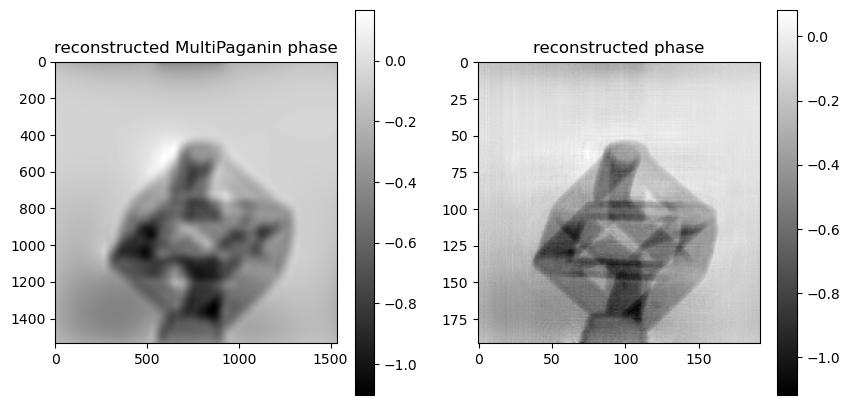

224) gammapsi=0.5 gammaprb=2, err=1.61531e+05
225) gammapsi=0.5 gammaprb=2, err=1.61358e+05
226) gammapsi=0.5 gammaprb=2, err=1.61201e+05
227) gammapsi=1 gammaprb=2, err=1.61126e+05
228) gammapsi=0.5 gammaprb=2, err=1.61060e+05
229) gammapsi=0.25 gammaprb=2, err=1.60926e+05
230) gammapsi=0 gammaprb=2, err=1.60765e+05
231) gammapsi=1 gammaprb=2, err=1.60436e+05
232) gammapsi=0.5 gammaprb=2, err=1.60267e+05
233) gammapsi=1 gammaprb=2, err=1.60240e+05
234) gammapsi=0 gammaprb=2, err=1.59885e+05
235) gammapsi=1 gammaprb=2, err=1.59749e+05
236) gammapsi=1 gammaprb=2, err=1.59672e+05
237) gammapsi=1 gammaprb=2, err=1.59582e+05
238) gammapsi=1 gammaprb=2, err=1.59500e+05
239) gammapsi=1 gammaprb=2, err=1.59434e+05
240) gammapsi=1 gammaprb=2, err=1.59324e+05
241) gammapsi=0.5 gammaprb=2, err=1.59248e+05
242) gammapsi=0.5 gammaprb=2, err=1.59148e+05
243) gammapsi=0.25 gammaprb=2, err=1.59002e+05
244) gammapsi=0.5 gammaprb=2, err=1.58888e+05
245) gammapsi=0 gammaprb=2, err=1.58683e+05
246) gamma

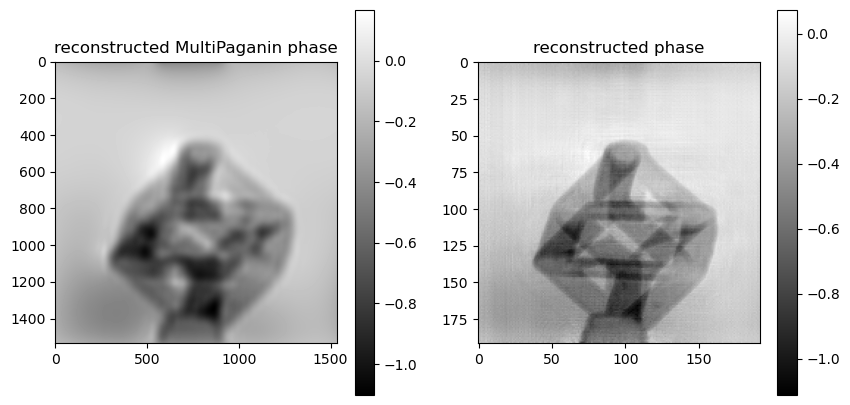

256) gammapsi=1 gammaprb=0.5, err=1.57201e+05
257) gammapsi=0.5 gammaprb=1.0, err=1.57137e+05
258) gammapsi=0.5 gammaprb=1.0, err=1.57088e+05
259) gammapsi=1 gammaprb=1.0, err=1.57024e+05
260) gammapsi=0.5 gammaprb=2, err=1.56949e+05
261) gammapsi=0.5 gammaprb=1.0, err=1.56874e+05
262) gammapsi=0.5 gammaprb=2, err=1.56782e+05
263) gammapsi=0.5 gammaprb=1.0, err=1.56730e+05
264) gammapsi=0.5 gammaprb=2, err=1.56633e+05
265) gammapsi=0 gammaprb=2, err=1.56487e+05
266) gammapsi=1 gammaprb=1.0, err=1.56347e+05
267) gammapsi=1 gammaprb=2, err=1.56236e+05
268) gammapsi=0 gammaprb=2, err=1.56040e+05
269) gammapsi=1 gammaprb=2, err=1.55935e+05
270) gammapsi=1 gammaprb=1.0, err=1.55868e+05
271) gammapsi=1 gammaprb=1.0, err=1.55725e+05
272) gammapsi=1 gammaprb=1.0, err=1.55633e+05
273) gammapsi=0.5 gammaprb=1.0, err=1.55568e+05
274) gammapsi=0 gammaprb=2, err=1.55468e+05
275) gammapsi=1 gammaprb=0.5, err=1.55407e+05
276) gammapsi=1 gammaprb=1.0, err=1.55301e+05
277) gammapsi=0.5 gammaprb=2, err=

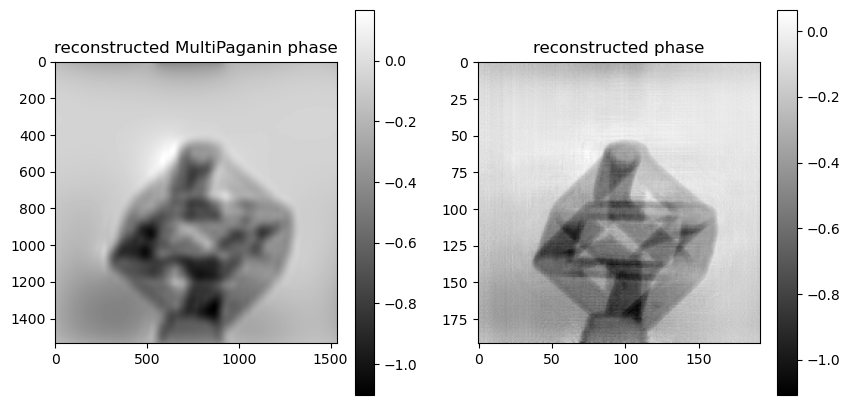

288) gammapsi=0.5 gammaprb=2, err=1.54358e+05
289) gammapsi=0.5 gammaprb=2, err=1.54231e+05
290) gammapsi=0.5 gammaprb=2, err=1.54079e+05
291) gammapsi=0.5 gammaprb=2, err=1.53844e+05
292) gammapsi=1 gammaprb=2, err=1.53574e+05
293) gammapsi=0.5 gammaprb=1.0, err=1.53426e+05
294) gammapsi=1 gammaprb=2, err=1.53258e+05
295) gammapsi=0.25 gammaprb=2, err=1.53097e+05
296) gammapsi=0.5 gammaprb=2, err=1.53023e+05
297) gammapsi=0 gammaprb=2, err=1.52811e+05
298) gammapsi=1 gammaprb=1.0, err=1.52428e+05
299) gammapsi=1 gammaprb=2, err=1.52235e+05
300) gammapsi=0.5 gammaprb=2, err=1.52141e+05
301) gammapsi=1 gammaprb=1.0, err=1.52068e+05
302) gammapsi=1 gammaprb=2, err=1.52049e+05
303) gammapsi=0.25 gammaprb=2, err=1.51939e+05
304) gammapsi=1 gammaprb=2, err=1.51889e+05
305) gammapsi=1 gammaprb=2, err=1.51828e+05
306) gammapsi=0.5 gammaprb=2, err=1.51746e+05
307) gammapsi=0.5 gammaprb=2, err=1.51668e+05
308) gammapsi=0.25 gammaprb=2, err=1.51604e+05
309) gammapsi=0.25 gammaprb=2, err=1.51541e

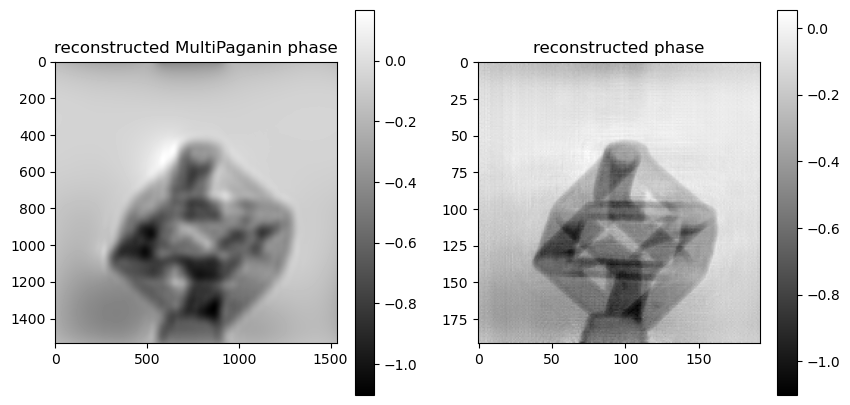

320) gammapsi=0.25 gammaprb=2, err=1.50398e+05
321) gammapsi=0.5 gammaprb=2, err=1.50326e+05
322) gammapsi=0.5 gammaprb=2, err=1.50280e+05
323) gammapsi=1 gammaprb=2, err=1.50213e+05
324) gammapsi=1 gammaprb=2, err=1.50164e+05
325) gammapsi=1 gammaprb=2, err=1.50160e+05
326) gammapsi=0.25 gammaprb=2, err=1.50050e+05
327) gammapsi=0.5 gammaprb=2, err=1.49968e+05
328) gammapsi=0.5 gammaprb=2, err=1.49873e+05
329) gammapsi=0.5 gammaprb=2, err=1.49790e+05
330) gammapsi=0.5 gammaprb=2, err=1.49694e+05
331) gammapsi=0.5 gammaprb=2, err=1.49643e+05
332) gammapsi=0.5 gammaprb=2, err=1.49543e+05
333) gammapsi=0.5 gammaprb=2, err=1.49451e+05
334) gammapsi=0.25 gammaprb=2, err=1.49341e+05
335) gammapsi=0.5 gammaprb=2, err=1.49249e+05
336) gammapsi=0.25 gammaprb=2, err=1.49184e+05
337) gammapsi=0.5 gammaprb=2, err=1.49040e+05
338) gammapsi=0.25 gammaprb=2, err=1.48934e+05
339) gammapsi=0.5 gammaprb=2, err=1.48870e+05
340) gammapsi=0.25 gammaprb=2, err=1.48709e+05
341) gammapsi=0.5 gammaprb=2, err=

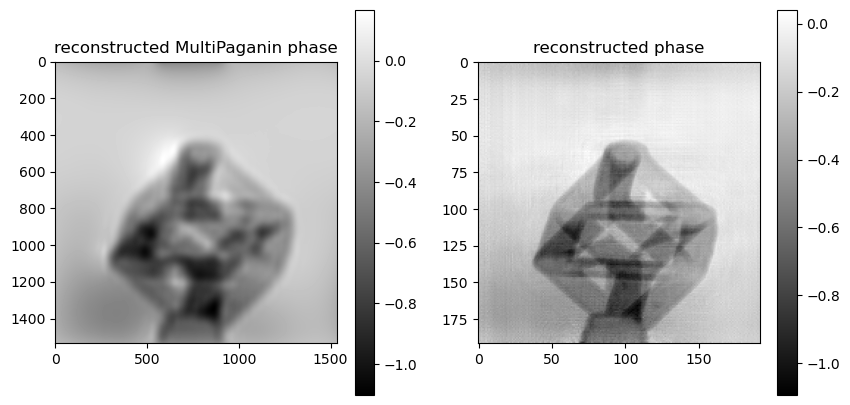

352) gammapsi=0.25 gammaprb=2, err=1.47477e+05
353) gammapsi=0 gammaprb=2, err=1.47395e+05
354) gammapsi=1 gammaprb=2, err=1.47114e+05
355) gammapsi=0.5 gammaprb=1.0, err=1.47017e+05
356) gammapsi=1 gammaprb=1.0, err=1.46792e+05
357) gammapsi=1 gammaprb=1.0, err=1.46664e+05
358) gammapsi=1 gammaprb=0.5, err=1.46602e+05
359) gammapsi=1 gammaprb=0.5, err=1.46524e+05
360) gammapsi=1 gammaprb=0.5, err=1.46492e+05
361) gammapsi=0.5 gammaprb=0.5, err=1.46388e+05
362) gammapsi=0.25 gammaprb=1.0, err=1.46314e+05
363) gammapsi=0.25 gammaprb=2, err=1.46280e+05
364) gammapsi=0 gammaprb=2, err=1.46196e+05
365) gammapsi=1 gammaprb=1.0, err=1.46067e+05
366) gammapsi=1 gammaprb=2, err=1.45996e+05
367) gammapsi=0.25 gammaprb=2, err=1.45950e+05
368) gammapsi=1 gammaprb=2, err=1.45925e+05
369) gammapsi=0.5 gammaprb=2, err=1.45871e+05
370) gammapsi=0.25 gammaprb=2, err=1.45820e+05
371) gammapsi=0.5 gammaprb=2, err=1.45730e+05
372) gammapsi=0.5 gammaprb=2, err=1.45666e+05
373) gammapsi=0.25 gammaprb=2, er

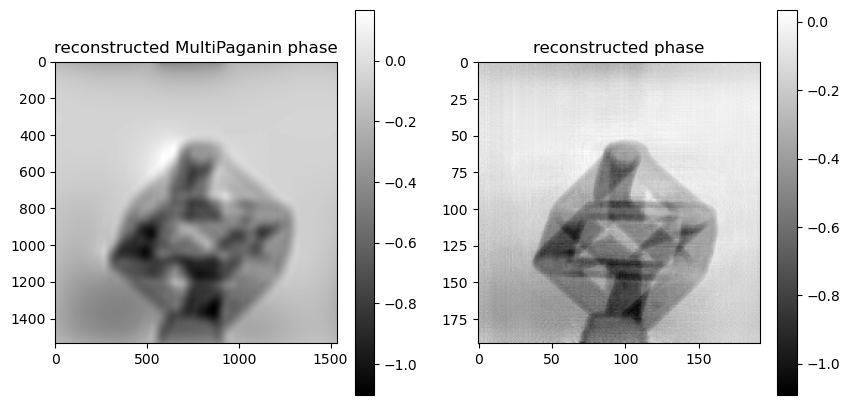

384) gammapsi=0 gammaprb=2, err=1.45005e+05
385) gammapsi=1 gammaprb=2, err=1.44843e+05
386) gammapsi=0.5 gammaprb=2, err=1.44766e+05
387) gammapsi=0.5 gammaprb=2, err=1.44687e+05
388) gammapsi=0.5 gammaprb=2, err=1.44629e+05
389) gammapsi=0.5 gammaprb=2, err=1.44581e+05
390) gammapsi=0.25 gammaprb=2, err=1.44533e+05
391) gammapsi=0.5 gammaprb=2, err=1.44485e+05
392) gammapsi=0.25 gammaprb=2, err=1.44441e+05
393) gammapsi=0.5 gammaprb=2, err=1.44396e+05
394) gammapsi=0.25 gammaprb=2, err=1.44352e+05
395) gammapsi=0.25 gammaprb=2, err=1.44304e+05
396) gammapsi=0.25 gammaprb=2, err=1.44271e+05
397) gammapsi=0 gammaprb=2, err=1.44199e+05
398) gammapsi=1 gammaprb=2, err=1.44113e+05
399) gammapsi=0.5 gammaprb=2, err=1.44079e+05
400) gammapsi=0.5 gammaprb=2, err=1.44014e+05
401) gammapsi=1 gammaprb=2, err=1.43977e+05
402) gammapsi=0.5 gammaprb=2, err=1.43948e+05
403) gammapsi=0.25 gammaprb=2, err=1.43903e+05
404) gammapsi=0.25 gammaprb=2, err=1.43865e+05
405) gammapsi=0 gammaprb=2, err=1.438

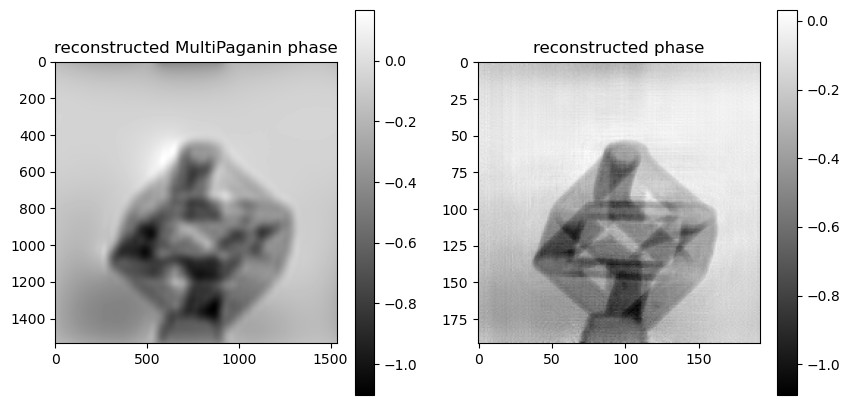

416) gammapsi=0.5 gammaprb=2, err=1.43307e+05
417) gammapsi=0.5 gammaprb=2, err=1.43265e+05
418) gammapsi=0.25 gammaprb=2, err=1.43206e+05
419) gammapsi=0.5 gammaprb=2, err=1.43142e+05
420) gammapsi=0.25 gammaprb=2, err=1.43093e+05
421) gammapsi=0.5 gammaprb=2, err=1.43044e+05
422) gammapsi=0.5 gammaprb=2, err=1.42993e+05
423) gammapsi=0.5 gammaprb=2, err=1.42937e+05
424) gammapsi=0.5 gammaprb=2, err=1.42902e+05
425) gammapsi=0.25 gammaprb=2, err=1.42820e+05
426) gammapsi=0.25 gammaprb=2, err=1.42742e+05
427) gammapsi=0.25 gammaprb=2, err=1.42682e+05
428) gammapsi=0.25 gammaprb=2, err=1.42599e+05
429) gammapsi=0.5 gammaprb=2, err=1.42506e+05
430) gammapsi=0.25 gammaprb=2, err=1.42439e+05
431) gammapsi=0.5 gammaprb=2, err=1.42305e+05
432) gammapsi=0.5 gammaprb=2, err=1.42228e+05
433) gammapsi=1 gammaprb=1.0, err=1.42024e+05
434) gammapsi=1 gammaprb=2, err=1.41791e+05
435) gammapsi=1 gammaprb=1.0, err=1.41623e+05
436) gammapsi=1 gammaprb=1.0, err=1.41506e+05
437) gammapsi=0.5 gammaprb=1.

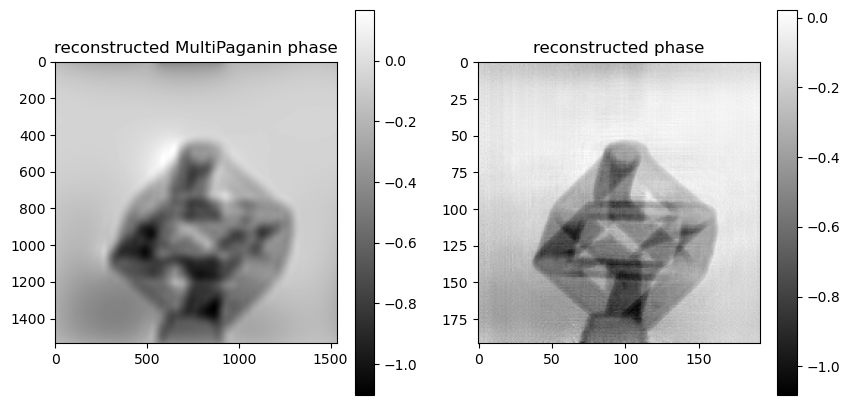

448) gammapsi=0.5 gammaprb=2, err=1.40810e+05
449) gammapsi=0.5 gammaprb=2, err=1.40762e+05
450) gammapsi=0.25 gammaprb=2, err=1.40709e+05
451) gammapsi=0.5 gammaprb=2, err=1.40672e+05
452) gammapsi=0.25 gammaprb=2, err=1.40631e+05
453) gammapsi=0.5 gammaprb=2, err=1.40583e+05
454) gammapsi=0 gammaprb=2, err=1.40521e+05
455) gammapsi=1 gammaprb=2, err=1.40368e+05
456) gammapsi=0.5 gammaprb=2, err=1.40277e+05
457) gammapsi=1 gammaprb=1.0, err=1.40205e+05
458) gammapsi=1 gammaprb=2, err=1.40171e+05
459) gammapsi=0 gammaprb=2, err=1.40100e+05
460) gammapsi=1 gammaprb=1.0, err=1.40040e+05
461) gammapsi=1 gammaprb=1.0, err=1.39980e+05
462) gammapsi=0.5 gammaprb=2, err=1.39953e+05
463) gammapsi=0.25 gammaprb=1.0, err=1.39937e+05
464) gammapsi=0.5 gammaprb=1.0, err=1.39913e+05
465) gammapsi=0.5 gammaprb=2, err=1.39900e+05
466) gammapsi=0 gammaprb=2, err=1.39830e+05
467) gammapsi=1 gammaprb=2, err=1.39778e+05
468) gammapsi=0.25 gammaprb=2, err=1.39712e+05
469) gammapsi=0.25 gammaprb=2, err=1.3

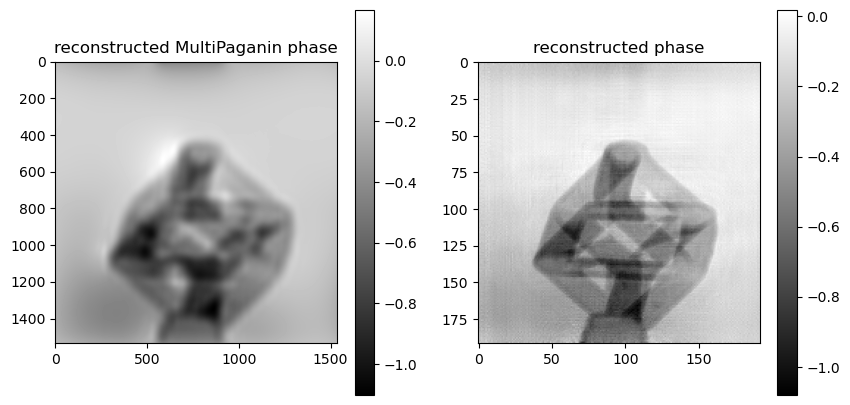

480) gammapsi=0.5 gammaprb=2, err=1.39226e+05
481) gammapsi=0.25 gammaprb=2, err=1.39172e+05
482) gammapsi=0.5 gammaprb=2, err=1.39122e+05
483) gammapsi=0 gammaprb=2, err=1.39028e+05
484) gammapsi=1 gammaprb=2, err=1.38923e+05
485) gammapsi=0.5 gammaprb=2, err=1.38869e+05
486) gammapsi=0.5 gammaprb=2, err=1.38799e+05
487) gammapsi=1 gammaprb=2, err=1.38743e+05
488) gammapsi=0.5 gammaprb=2, err=1.38697e+05
489) gammapsi=0.25 gammaprb=2, err=1.38650e+05
490) gammapsi=0.25 gammaprb=2, err=1.38613e+05
491) gammapsi=0 gammaprb=2, err=1.38565e+05
492) gammapsi=1 gammaprb=2, err=1.38493e+05
493) gammapsi=0.5 gammaprb=2, err=1.38449e+05
494) gammapsi=0.5 gammaprb=2, err=1.38415e+05
495) gammapsi=0.25 gammaprb=2, err=1.38380e+05
496) gammapsi=0.5 gammaprb=2, err=1.38346e+05
497) gammapsi=0.5 gammaprb=2, err=1.38326e+05
498) gammapsi=0.5 gammaprb=2, err=1.38293e+05
499) gammapsi=0.5 gammaprb=2, err=1.38266e+05
500) gammapsi=0.25 gammaprb=2, err=1.38236e+05
501) gammapsi=0.5 gammaprb=2, err=1.382

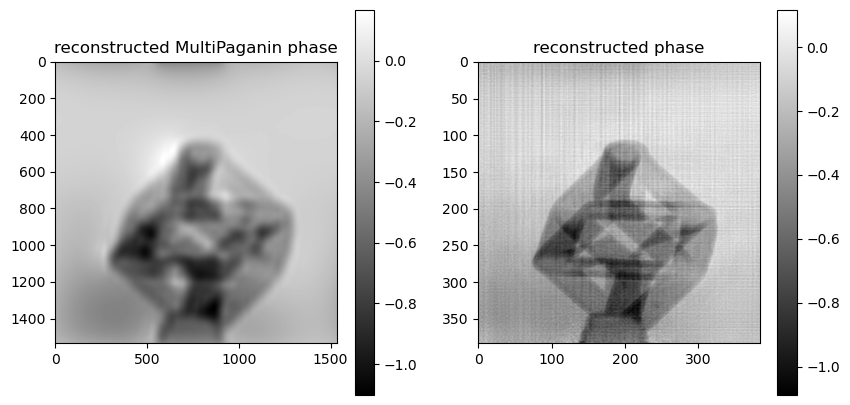

0) gammapsi=1 gammaprb=2, err=8.30261e+07
0.5441875457763672
fwd psi 1.04e+01, adj psi 1.67e+01, grad psi 5.66e+00,fwd d 9.19e+00, line search 6.49e+00
fwd prb 1.27e+01, adj prb 1.53e+01, grad prb 9.23e-01,fwd dprb 1.35e+01, line search 9.19e+00
100.0
1) gammapsi=1 gammaprb=2, err=5.76759e+06
0.5360302925109863
fwd psi 1.02e+01, adj psi 1.79e+01, grad psi 5.57e+00,fwd d 9.62e+00, line search 7.63e+00
fwd prb 1.23e+01, adj prb 1.55e+01, grad prb 7.43e-01,fwd dprb 1.22e+01, line search 8.37e+00
100.0
2) gammapsi=1 gammaprb=2, err=3.72005e+06
3) gammapsi=1 gammaprb=2, err=2.56997e+06
4) gammapsi=1 gammaprb=2, err=2.02199e+06
5) gammapsi=1 gammaprb=0, err=1.77831e+06
6) gammapsi=1 gammaprb=2, err=1.51544e+06
7) gammapsi=1 gammaprb=1.0, err=1.46927e+06
8) gammapsi=1 gammaprb=0.5, err=1.32005e+06
9) gammapsi=1 gammaprb=0, err=1.28570e+06
10) gammapsi=1 gammaprb=2, err=1.16991e+06
11) gammapsi=1 gammaprb=2, err=1.12077e+06
12) gammapsi=1 gammaprb=2, err=1.06609e+06
13) gammapsi=0.5 gammaprb=2

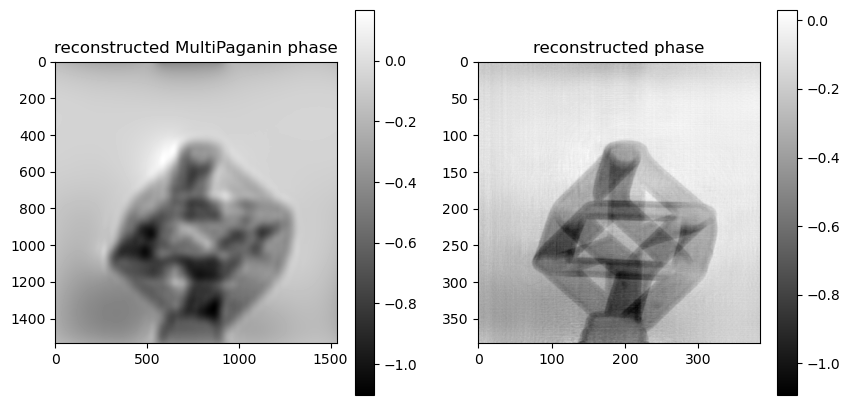

32) gammapsi=0.5 gammaprb=2, err=6.74858e+05
33) gammapsi=0.25 gammaprb=1.0, err=6.62686e+05
34) gammapsi=0.25 gammaprb=2, err=6.54080e+05
35) gammapsi=0 gammaprb=2, err=6.47527e+05
36) gammapsi=1 gammaprb=1.0, err=6.04534e+05
37) gammapsi=1 gammaprb=0.5, err=5.83118e+05
38) gammapsi=1 gammaprb=1.0, err=5.74308e+05
39) gammapsi=1 gammaprb=0, err=5.71954e+05
40) gammapsi=1 gammaprb=2, err=5.65294e+05
41) gammapsi=0.5 gammaprb=2, err=5.58575e+05
42) gammapsi=1 gammaprb=1.0, err=5.54730e+05
43) gammapsi=0.5 gammaprb=0.5, err=5.52787e+05
44) gammapsi=0.25 gammaprb=0.25, err=5.51028e+05
45) gammapsi=0.5 gammaprb=0, err=5.49714e+05
46) gammapsi=0.5 gammaprb=2, err=5.46720e+05
47) gammapsi=0 gammaprb=2, err=5.42908e+05
48) gammapsi=1 gammaprb=1.0, err=5.36907e+05
49) gammapsi=0.5 gammaprb=0.5, err=5.33163e+05
50) gammapsi=0.5 gammaprb=0, err=5.32656e+05
51) gammapsi=1 gammaprb=2, err=5.29456e+05
52) gammapsi=1 gammaprb=2, err=5.28084e+05
53) gammapsi=0.25 gammaprb=2, err=5.25298e+05
54) gamma

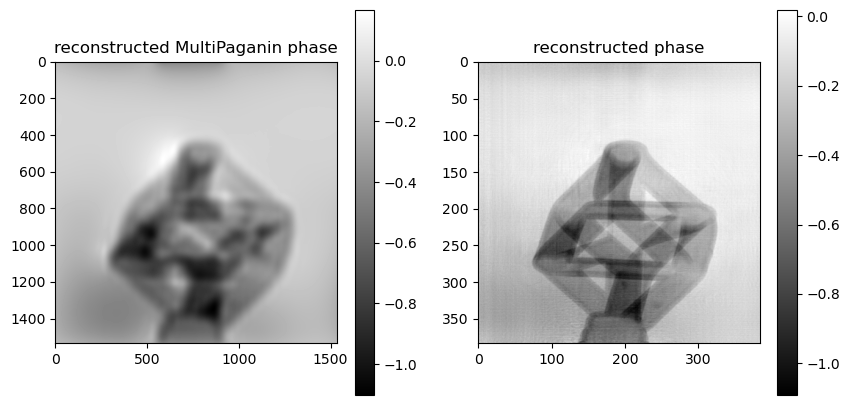

64) gammapsi=1 gammaprb=1.0, err=4.97502e+05
65) gammapsi=0.5 gammaprb=1.0, err=4.96300e+05
66) gammapsi=0.5 gammaprb=0, err=4.96154e+05
67) gammapsi=1 gammaprb=2, err=4.94713e+05
68) gammapsi=0 gammaprb=2, err=4.93188e+05
69) gammapsi=1 gammaprb=2, err=4.91311e+05
70) gammapsi=0.5 gammaprb=1.0, err=4.90168e+05
71) gammapsi=0.25 gammaprb=0.5, err=4.88882e+05
72) gammapsi=0.5 gammaprb=2, err=4.87869e+05
73) gammapsi=0.25 gammaprb=2, err=4.86695e+05
74) gammapsi=0.25 gammaprb=2, err=4.86296e+05
75) gammapsi=0.5 gammaprb=2, err=4.85255e+05
76) gammapsi=0.25 gammaprb=2, err=4.83914e+05
77) gammapsi=0.5 gammaprb=2, err=4.82482e+05
78) gammapsi=0.5 gammaprb=2, err=4.81950e+05
79) gammapsi=0.25 gammaprb=2, err=4.80789e+05
80) gammapsi=0.25 gammaprb=2, err=4.79253e+05
81) gammapsi=0.25 gammaprb=2, err=4.78104e+05
82) gammapsi=0.25 gammaprb=2, err=4.76795e+05
83) gammapsi=0.25 gammaprb=2, err=4.75282e+05
84) gammapsi=0 gammaprb=2, err=4.74035e+05
85) gammapsi=1 gammaprb=2, err=4.69785e+05
86) g

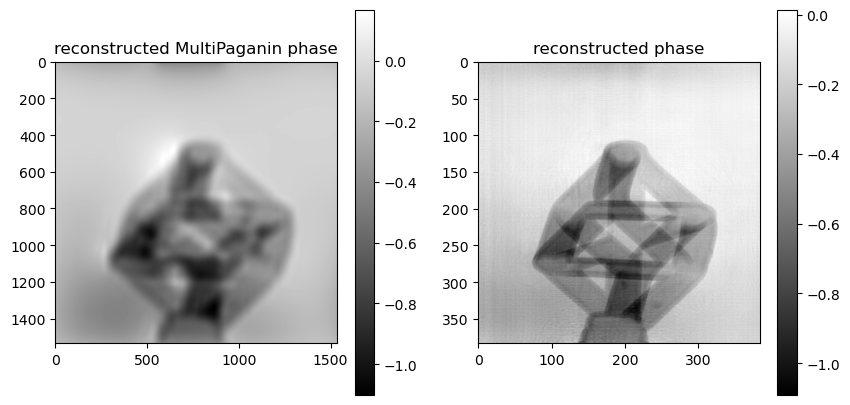

96) gammapsi=0.25 gammaprb=2, err=4.56997e+05
97) gammapsi=0.5 gammaprb=2, err=4.56533e+05
98) gammapsi=0.5 gammaprb=2, err=4.56107e+05
99) gammapsi=0.5 gammaprb=2, err=4.55548e+05
100) gammapsi=1 gammaprb=2, err=4.54851e+05
101) gammapsi=0.25 gammaprb=2, err=4.54080e+05
102) gammapsi=0.5 gammaprb=2, err=4.53265e+05
103) gammapsi=0.25 gammaprb=2, err=4.52628e+05
104) gammapsi=0.5 gammaprb=2, err=4.51854e+05
105) gammapsi=0.25 gammaprb=2, err=4.51066e+05
106) gammapsi=0.5 gammaprb=2, err=4.50337e+05
107) gammapsi=0.25 gammaprb=2, err=4.49780e+05
108) gammapsi=0.5 gammaprb=2, err=4.49239e+05
109) gammapsi=0 gammaprb=2, err=4.47667e+05
110) gammapsi=1 gammaprb=2, err=4.44874e+05
111) gammapsi=0.5 gammaprb=1.0, err=4.42659e+05
112) gammapsi=1 gammaprb=1.0, err=4.41528e+05
113) gammapsi=1 gammaprb=1.0, err=4.40717e+05
114) gammapsi=1 gammaprb=0, err=4.40656e+05
115) gammapsi=1 gammaprb=2, err=4.39956e+05
116) gammapsi=0 gammaprb=2, err=4.39246e+05
117) gammapsi=1 gammaprb=2, err=4.38434e+05

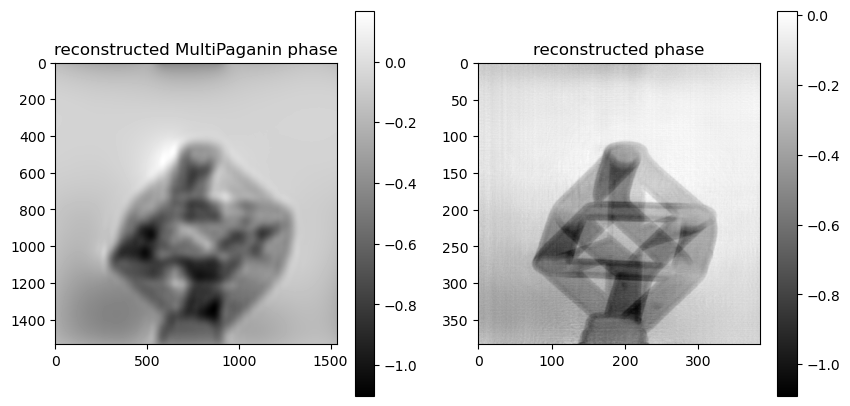

128) gammapsi=0.5 gammaprb=2, err=4.31114e+05
129) gammapsi=1 gammaprb=1.0, err=4.31044e+05
130) gammapsi=0.5 gammaprb=2, err=4.30501e+05
131) gammapsi=0 gammaprb=2, err=4.29157e+05
132) gammapsi=1 gammaprb=2, err=4.28455e+05
133) gammapsi=1 gammaprb=0.5, err=4.28277e+05
134) gammapsi=1 gammaprb=1.0, err=4.27905e+05
135) gammapsi=1 gammaprb=2, err=4.27536e+05
136) gammapsi=0.5 gammaprb=2, err=4.27328e+05
137) gammapsi=1 gammaprb=2, err=4.27080e+05
138) gammapsi=0.5 gammaprb=2, err=4.26682e+05
139) gammapsi=1 gammaprb=2, err=4.25883e+05
140) gammapsi=0.25 gammaprb=2, err=4.25245e+05
141) gammapsi=1 gammaprb=2, err=4.24725e+05
142) gammapsi=1 gammaprb=2, err=4.23932e+05
143) gammapsi=1 gammaprb=2, err=4.23306e+05
144) gammapsi=1 gammaprb=1.0, err=4.22671e+05
145) gammapsi=1 gammaprb=1.0, err=4.21626e+05
146) gammapsi=0.5 gammaprb=2, err=4.21251e+05
147) gammapsi=0.5 gammaprb=1.0, err=4.20717e+05
148) gammapsi=1 gammaprb=1.0, err=4.19933e+05
149) gammapsi=1 gammaprb=2, err=4.19416e+05
150

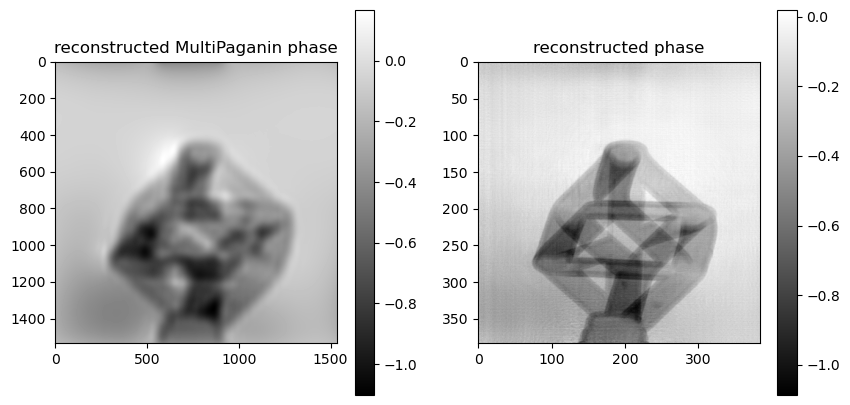

160) gammapsi=0.5 gammaprb=2, err=4.14318e+05
161) gammapsi=0.25 gammaprb=2, err=4.13952e+05
162) gammapsi=0.5 gammaprb=1.0, err=4.13291e+05
163) gammapsi=1 gammaprb=1.0, err=4.12631e+05
164) gammapsi=0.5 gammaprb=1.0, err=4.12067e+05
165) gammapsi=0.5 gammaprb=1.0, err=4.11509e+05
166) gammapsi=0.5 gammaprb=0.25, err=4.11027e+05
167) gammapsi=0.5 gammaprb=0.5, err=4.10305e+05
168) gammapsi=0.25 gammaprb=1.0, err=4.09839e+05
169) gammapsi=0.5 gammaprb=1.0, err=4.09033e+05
170) gammapsi=1 gammaprb=0.25, err=4.08563e+05
171) gammapsi=1 gammaprb=0, err=4.07870e+05
172) gammapsi=1 gammaprb=2, err=4.07275e+05
173) gammapsi=0.5 gammaprb=2, err=4.06389e+05
174) gammapsi=1 gammaprb=1.0, err=4.05823e+05
175) gammapsi=1 gammaprb=0, err=4.05644e+05
176) gammapsi=1 gammaprb=2, err=4.04965e+05
177) gammapsi=1 gammaprb=2, err=4.04258e+05
178) gammapsi=1 gammaprb=2, err=4.03605e+05
179) gammapsi=1 gammaprb=0, err=4.03528e+05
180) gammapsi=1 gammaprb=2, err=4.02910e+05
181) gammapsi=1 gammaprb=2, err=

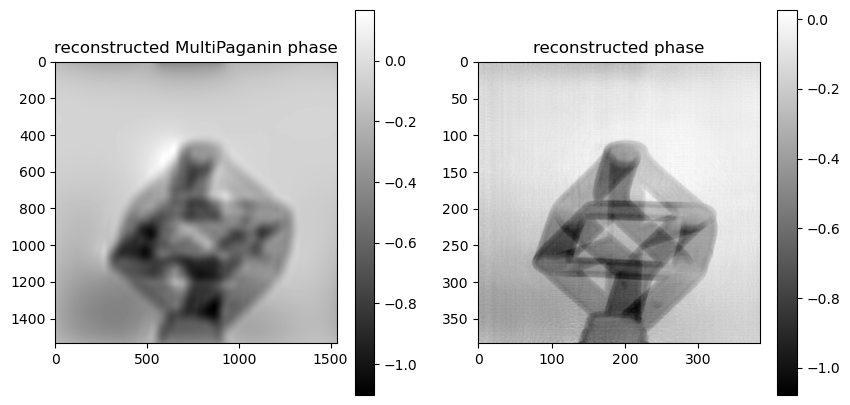

192) gammapsi=0.5 gammaprb=2, err=3.98638e+05
193) gammapsi=0.5 gammaprb=2, err=3.98329e+05
194) gammapsi=0.25 gammaprb=2, err=3.97962e+05
195) gammapsi=0.25 gammaprb=2, err=3.97561e+05
196) gammapsi=0.25 gammaprb=2, err=3.97207e+05
197) gammapsi=0.25 gammaprb=2, err=3.96878e+05
198) gammapsi=0.25 gammaprb=2, err=3.96619e+05
199) gammapsi=0.25 gammaprb=2, err=3.96327e+05
200) gammapsi=0.25 gammaprb=2, err=3.96030e+05
201) gammapsi=0.25 gammaprb=2, err=3.95725e+05
202) gammapsi=0.25 gammaprb=2, err=3.95426e+05
203) gammapsi=0.25 gammaprb=2, err=3.95100e+05
204) gammapsi=0.25 gammaprb=2, err=3.94797e+05
205) gammapsi=0.25 gammaprb=2, err=3.94519e+05
206) gammapsi=0.25 gammaprb=2, err=3.94226e+05
207) gammapsi=0.25 gammaprb=2, err=3.94049e+05
208) gammapsi=0 gammaprb=2, err=3.93579e+05
209) gammapsi=1 gammaprb=2, err=3.92187e+05
210) gammapsi=1 gammaprb=1.0, err=3.91426e+05
211) gammapsi=1 gammaprb=2, err=3.91065e+05
212) gammapsi=0.5 gammaprb=2, err=3.90717e+05
213) gammapsi=0.5 gammaprb

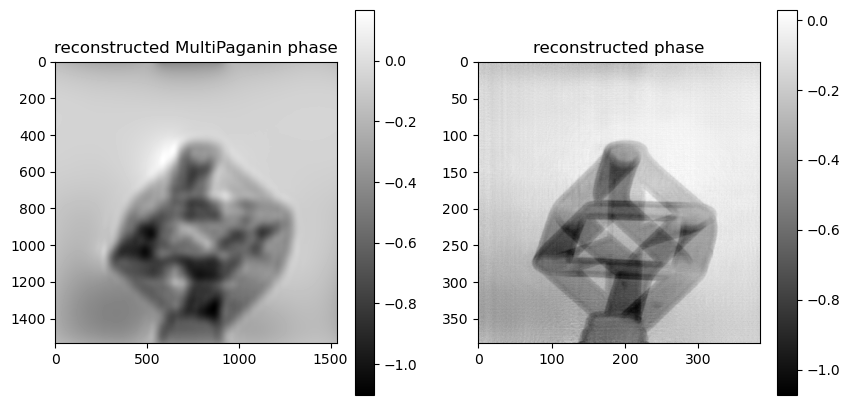

224) gammapsi=1 gammaprb=0.5, err=3.88030e+05
225) gammapsi=1 gammaprb=1.0, err=3.87728e+05
226) gammapsi=0 gammaprb=2, err=3.87488e+05
227) gammapsi=1 gammaprb=2, err=3.87143e+05
228) gammapsi=1 gammaprb=2, err=3.86690e+05
229) gammapsi=0.25 gammaprb=2, err=3.86500e+05
230) gammapsi=1 gammaprb=2, err=3.86365e+05
231) gammapsi=0 gammaprb=2, err=3.85987e+05
232) gammapsi=1 gammaprb=2, err=3.85861e+05
233) gammapsi=0 gammaprb=2, err=3.85640e+05
234) gammapsi=1 gammaprb=2, err=3.85502e+05
235) gammapsi=0.25 gammaprb=2, err=3.85288e+05
236) gammapsi=0.25 gammaprb=2, err=3.85177e+05
237) gammapsi=1 gammaprb=2, err=3.85021e+05
238) gammapsi=1 gammaprb=2, err=3.84838e+05
239) gammapsi=1 gammaprb=2, err=3.84605e+05
240) gammapsi=0.5 gammaprb=2, err=3.84390e+05
241) gammapsi=1 gammaprb=2, err=3.84146e+05
242) gammapsi=0.5 gammaprb=2, err=3.83844e+05
243) gammapsi=1 gammaprb=2, err=3.83502e+05
244) gammapsi=0.5 gammaprb=2, err=3.83212e+05
245) gammapsi=1 gammaprb=2, err=3.82759e+05
246) gammapsi

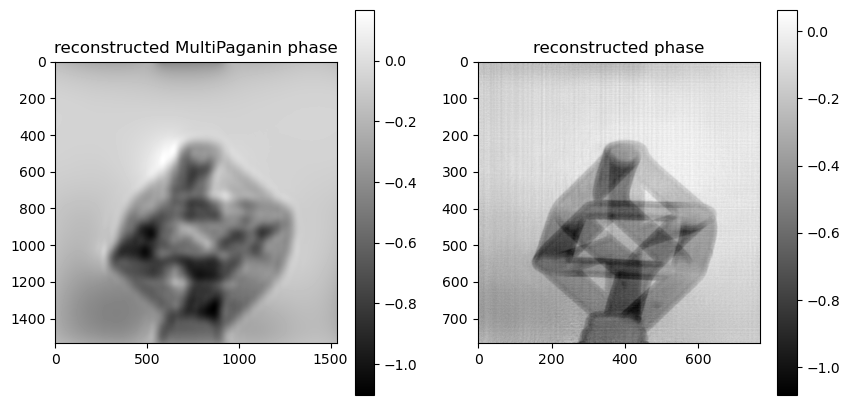

0) gammapsi=1 gammaprb=2, err=1.33895e+08
2.119856119155884
fwd psi 1.04e+01, adj psi 1.79e+01, grad psi 6.53e+00,fwd d 1.03e+01, line search 7.43e+00
fwd prb 1.16e+01, adj prb 1.60e+01, grad prb 6.71e-01,fwd dprb 1.13e+01, line search 7.84e+00
100.0
1) gammapsi=1 gammaprb=2, err=1.07474e+07
2.108442783355713
fwd psi 1.04e+01, adj psi 1.78e+01, grad psi 6.44e+00,fwd d 1.04e+01, line search 7.36e+00
fwd prb 1.16e+01, adj prb 1.58e+01, grad prb 9.34e-01,fwd dprb 1.14e+01, line search 7.85e+00
100.0
2) gammapsi=1 gammaprb=2, err=8.09855e+06
3) gammapsi=1 gammaprb=2, err=6.10677e+06
4) gammapsi=1 gammaprb=2, err=5.07006e+06
5) gammapsi=1 gammaprb=1.0, err=4.40963e+06
6) gammapsi=1 gammaprb=0, err=4.03834e+06
7) gammapsi=1 gammaprb=2, err=3.70639e+06
8) gammapsi=1 gammaprb=2, err=3.46524e+06
9) gammapsi=1 gammaprb=2, err=3.26640e+06
10) gammapsi=1 gammaprb=0, err=3.19076e+06
11) gammapsi=1 gammaprb=2, err=3.04574e+06
12) gammapsi=1 gammaprb=2, err=2.96763e+06
13) gammapsi=1 gammaprb=2, err=

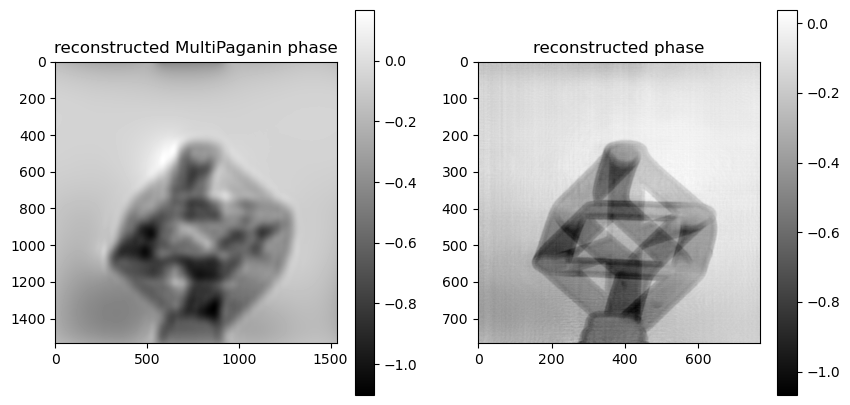

32) gammapsi=1 gammaprb=1.0, err=2.22389e+06
33) gammapsi=1 gammaprb=1.0, err=2.20608e+06
34) gammapsi=1 gammaprb=0.25, err=2.19591e+06
35) gammapsi=1 gammaprb=0.5, err=2.18536e+06
36) gammapsi=1 gammaprb=0.25, err=2.18221e+06
37) gammapsi=1 gammaprb=0.25, err=2.17452e+06
38) gammapsi=1 gammaprb=0, err=2.16916e+06
39) gammapsi=1 gammaprb=2, err=2.15898e+06
40) gammapsi=0.5 gammaprb=2, err=2.14659e+06
41) gammapsi=1 gammaprb=2, err=2.14133e+06
42) gammapsi=0.5 gammaprb=2, err=2.13613e+06
43) gammapsi=0.5 gammaprb=1.0, err=2.12964e+06
44) gammapsi=0.5 gammaprb=2, err=2.12338e+06
45) gammapsi=0.25 gammaprb=2, err=2.11865e+06
46) gammapsi=1 gammaprb=1.0, err=2.11479e+06
47) gammapsi=1 gammaprb=2, err=2.10760e+06
48) gammapsi=0.25 gammaprb=2, err=2.09949e+06
49) gammapsi=0.5 gammaprb=2, err=2.09466e+06
50) gammapsi=0.25 gammaprb=2, err=2.09171e+06
51) gammapsi=0.25 gammaprb=2, err=2.08420e+06
52) gammapsi=0.25 gammaprb=2, err=2.07786e+06
53) gammapsi=0.25 gammaprb=2, err=2.07303e+06
54) gam

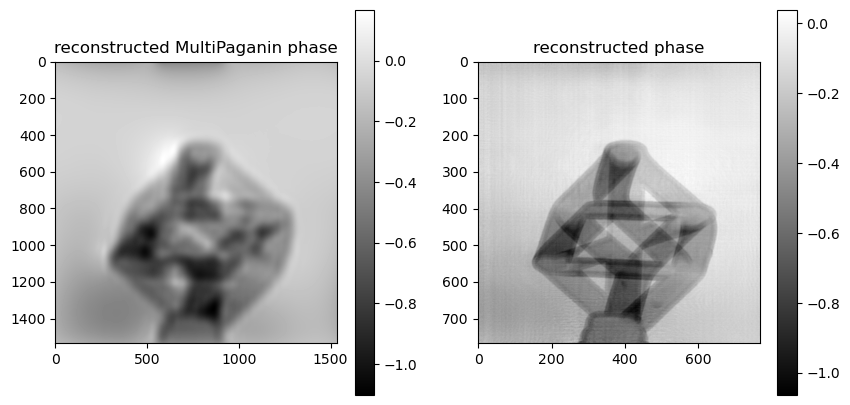

64) gammapsi=1 gammaprb=1.0, err=2.00178e+06
65) gammapsi=1 gammaprb=1.0, err=1.99866e+06
66) gammapsi=0.5 gammaprb=2, err=1.99618e+06
67) gammapsi=0.5 gammaprb=2, err=1.99402e+06
68) gammapsi=1 gammaprb=2, err=1.99172e+06
69) gammapsi=1 gammaprb=2, err=1.99062e+06
70) gammapsi=1 gammaprb=2, err=1.98931e+06
71) gammapsi=0.5 gammaprb=2, err=1.98749e+06
72) gammapsi=0.5 gammaprb=2, err=1.98495e+06
73) gammapsi=0.5 gammaprb=2, err=1.98312e+06
74) gammapsi=0.25 gammaprb=2, err=1.98026e+06
75) gammapsi=0.5 gammaprb=2, err=1.97784e+06
76) gammapsi=0.25 gammaprb=2, err=1.97548e+06
77) gammapsi=0.5 gammaprb=2, err=1.97259e+06
78) gammapsi=0.25 gammaprb=2, err=1.97011e+06
79) gammapsi=0.25 gammaprb=2, err=1.96726e+06
80) gammapsi=0.25 gammaprb=2, err=1.96527e+06
81) gammapsi=0.25 gammaprb=2, err=1.96343e+06
82) gammapsi=0.25 gammaprb=2, err=1.96035e+06
83) gammapsi=0.25 gammaprb=2, err=1.95809e+06
84) gammapsi=0 gammaprb=2, err=1.95490e+06
85) gammapsi=1 gammaprb=2, err=1.94518e+06
86) gammapsi

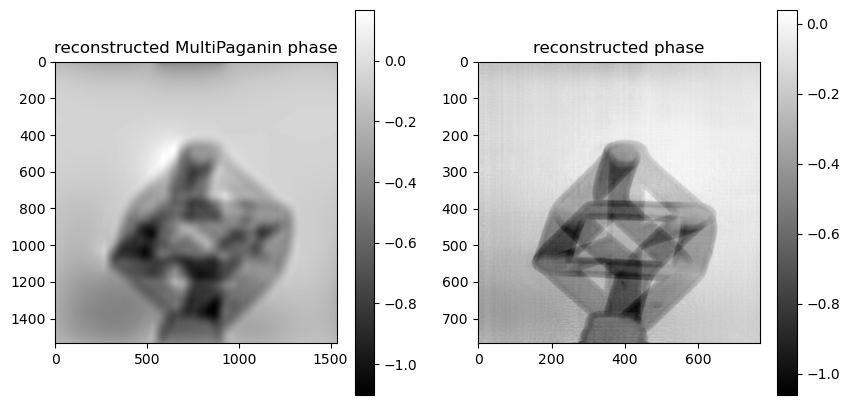

96) gammapsi=1 gammaprb=0, err=1.91930e+06
97) gammapsi=1 gammaprb=2, err=1.91771e+06
98) gammapsi=0.5 gammaprb=2, err=1.91680e+06
99) gammapsi=1 gammaprb=0, err=1.91574e+06
100) gammapsi=0.5 gammaprb=2, err=1.91335e+06
101) gammapsi=0 gammaprb=2, err=1.90927e+06
102) gammapsi=1 gammaprb=2, err=1.90644e+06
103) gammapsi=1 gammaprb=1.0, err=1.90485e+06
104) gammapsi=1 gammaprb=0, err=1.90431e+06
105) gammapsi=1 gammaprb=2, err=1.90281e+06
106) gammapsi=0.25 gammaprb=2, err=1.90113e+06
107) gammapsi=1 gammaprb=2, err=1.89951e+06
108) gammapsi=1 gammaprb=0, err=1.89915e+06
109) gammapsi=1 gammaprb=2, err=1.89767e+06
110) gammapsi=1 gammaprb=1.0, err=1.89643e+06
111) gammapsi=1 gammaprb=0.25, err=1.89467e+06
112) gammapsi=1 gammaprb=0, err=1.89440e+06
113) gammapsi=1 gammaprb=2, err=1.89134e+06
114) gammapsi=1 gammaprb=2, err=1.88905e+06
115) gammapsi=1 gammaprb=2, err=1.88535e+06
116) gammapsi=1 gammaprb=1.0, err=1.88321e+06
117) gammapsi=1 gammaprb=0, err=1.88287e+06
118) gammapsi=1 gamm

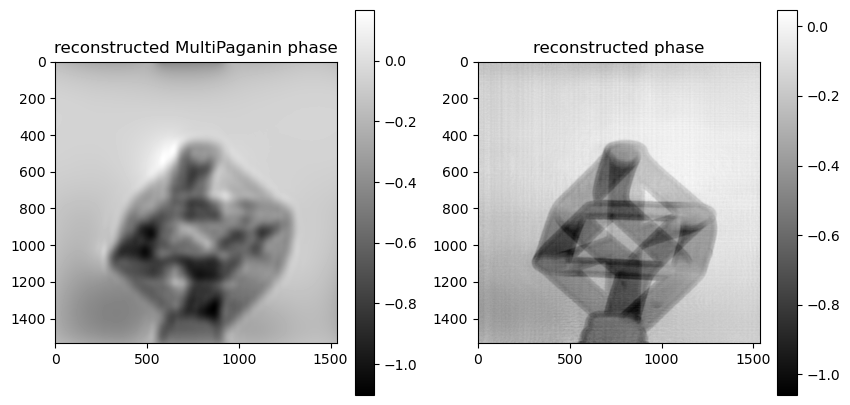

0) gammapsi=1 gammaprb=2, err=2.18592e+08
8.211053848266602
fwd psi 1.04e+01, adj psi 1.76e+01, grad psi 6.11e+00,fwd d 1.02e+01, line search 7.23e+00
fwd prb 1.15e+01, adj prb 1.65e+01, grad prb 1.05e+00,fwd dprb 1.14e+01, line search 8.04e+00
100.0
1) gammapsi=1 gammaprb=2, err=2.91579e+07
8.224103212356567
fwd psi 1.03e+01, adj psi 1.77e+01, grad psi 6.30e+00,fwd d 1.03e+01, line search 7.33e+00
fwd prb 1.14e+01, adj prb 1.63e+01, grad prb 8.99e-01,fwd dprb 1.14e+01, line search 8.08e+00
100.0
2) gammapsi=1 gammaprb=2, err=2.41399e+07
3) gammapsi=1 gammaprb=2, err=1.98433e+07
4) gammapsi=1 gammaprb=2, err=1.76415e+07
5) gammapsi=1 gammaprb=2, err=1.60440e+07
6) gammapsi=1 gammaprb=1.0, err=1.49756e+07
7) gammapsi=1 gammaprb=1.0, err=1.42959e+07
8) gammapsi=1 gammaprb=0.25, err=1.37810e+07
9) gammapsi=1 gammaprb=0.5, err=1.33347e+07
10) gammapsi=1 gammaprb=0.5, err=1.29801e+07
11) gammapsi=1 gammaprb=1.0, err=1.26941e+07
12) gammapsi=1 gammaprb=1.0, err=1.24658e+07
13) gammapsi=1 gam

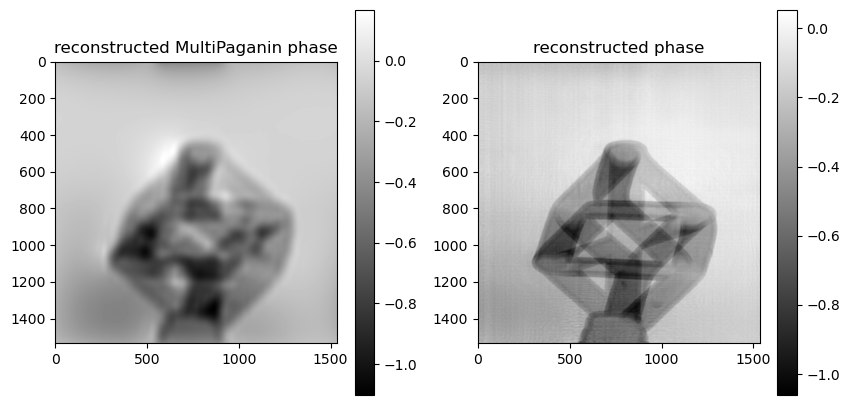

32) gammapsi=0.25 gammaprb=1.0, err=1.09351e+07
33) gammapsi=0.5 gammaprb=2, err=1.09000e+07
34) gammapsi=0.25 gammaprb=2, err=1.08702e+07
35) gammapsi=0.5 gammaprb=2, err=1.08599e+07
36) gammapsi=0.25 gammaprb=2, err=1.08197e+07
37) gammapsi=0.5 gammaprb=2, err=1.07800e+07
38) gammapsi=0.5 gammaprb=2, err=1.07650e+07
39) gammapsi=0.5 gammaprb=2, err=1.07263e+07
40) gammapsi=0.5 gammaprb=2, err=1.07062e+07
41) gammapsi=0.5 gammaprb=2, err=1.06733e+07
42) gammapsi=0.5 gammaprb=2, err=1.06653e+07
43) gammapsi=0.25 gammaprb=2, err=1.06286e+07
44) gammapsi=0.25 gammaprb=2, err=1.05967e+07
45) gammapsi=0.25 gammaprb=2, err=1.05846e+07
46) gammapsi=0.25 gammaprb=2, err=1.05643e+07
47) gammapsi=0.25 gammaprb=2, err=1.05389e+07
48) gammapsi=0 gammaprb=2, err=1.05232e+07
49) gammapsi=1 gammaprb=2, err=1.04050e+07
50) gammapsi=1 gammaprb=1.0, err=1.03163e+07
51) gammapsi=1 gammaprb=1.0, err=1.02545e+07
52) gammapsi=1 gammaprb=1.0, err=1.02209e+07
53) gammapsi=1 gammaprb=0.5, err=1.01866e+07
54) 

: 

In [21]:
import scipy as sp
def downsample(data, binning):
    res = data.copy()
    for k in range(binning):
        res = 0.5*(res[..., ::2,:]+res[..., 1::2,:])
        res = 0.5*(res[..., ::2]+res[..., 1::2])        
    return res

lbinninga = [3,2,1,0]
iters = [512,256,128,64]
rec = downsample(rec0,lbinninga[0])
prb = downsample(prb0,lbinninga[0])       
for k,lbinning in enumerate(lbinninga):
    n = n0//2**lbinning
    ne = ne0//2**lbinning
    voxelsize = voxelsize0*2**lbinning
    shifts_rec = shifts_rec0//2**lbinning
    shifts_probe = shifts_probe0//2**lbinning
    print(f'{n=},{ne=},{voxelsize=}')   
    
    data = downsample(data0,lbinning)
    data_ref = downsample(data_ref0,lbinning)
    
    
    pslv = holotomo.SolverHolo(ntheta, n, ne, ptheta, voxelsize, energy, distances, norm_magnifications, distances2,same_probe=same_probe) 
    pslv0 = holotomo.SolverHolo(1, n, ne, 1, voxelsize, energy, distances, norm_magnifications, distances2,same_probe=same_probe)     
    rec,prb,conv = cg_holo_batch2(pslv, pslv0, data, data_ref, rec, prb, iters[k], shifts_rec,shifts_probe, True,True,1,32, 1,2)
    
    rec = np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(rec)))
    rec = np.pad(rec,((0,0),(rec.shape[1]//2,rec.shape[1]//2),(rec.shape[1]//2,rec.shape[1]//2)))
    rec = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(rec)))*4
    rec = rec.astype('complex64')
    
    prb = np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(prb)))
    prb = np.pad(prb,((0,0),(prb.shape[1]//2,prb.shape[1]//2),(prb.shape[1]//2,prb.shape[1]//2)))
    prb = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(prb)))*4
    prb = prb.astype('complex64')
    
    